In [ ]:
!pip install vit_pytorch

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from vit_pytorch import SimpleViT

# Device

In [2]:
print(f"Torch: {torch.__version__}")

Torch: 1.7.1


In [3]:
torch.cuda.is_available()

True

In [4]:
device = 'cuda'

# Load Data

In [5]:
train_dir = './Training'
test_dir = './Testing'

In [6]:
labels = os.listdir(train_dir)
print(labels)
print(len(labels))

['glioma', 'meningioma', 'notumor', 'pituitary']
4


In [7]:
train_list = []
train_labels_list = []
test_list = []
test_labels_list = []
for i in labels:
    train_path = os.path.join(train_dir,i)
    temp1 = glob.glob(os.path.join(train_path,'*.jpg'))
    train_list += temp1
    temp2 = [i for j in range(len(temp1))]
    train_labels_list += temp2
    test_path = os.path.join(test_dir,i)
    temp3 = glob.glob(os.path.join(test_path,'*.jpg'))
    test_list += temp3
    temp4 = [i for j in range(len(temp3))]
    test_labels_list += temp4

In [8]:
print(f"Train Data: {len(train_list)}")
print(f"Train Labels: {len(train_labels_list)}")
print(f"Test Data: {len(test_list)}")
print(f"Test Labels: {len(test_labels_list)}")

Train Data: 5712
Train Labels: 5712
Test Data: 1311
Test Labels: 1311


# Random Plots

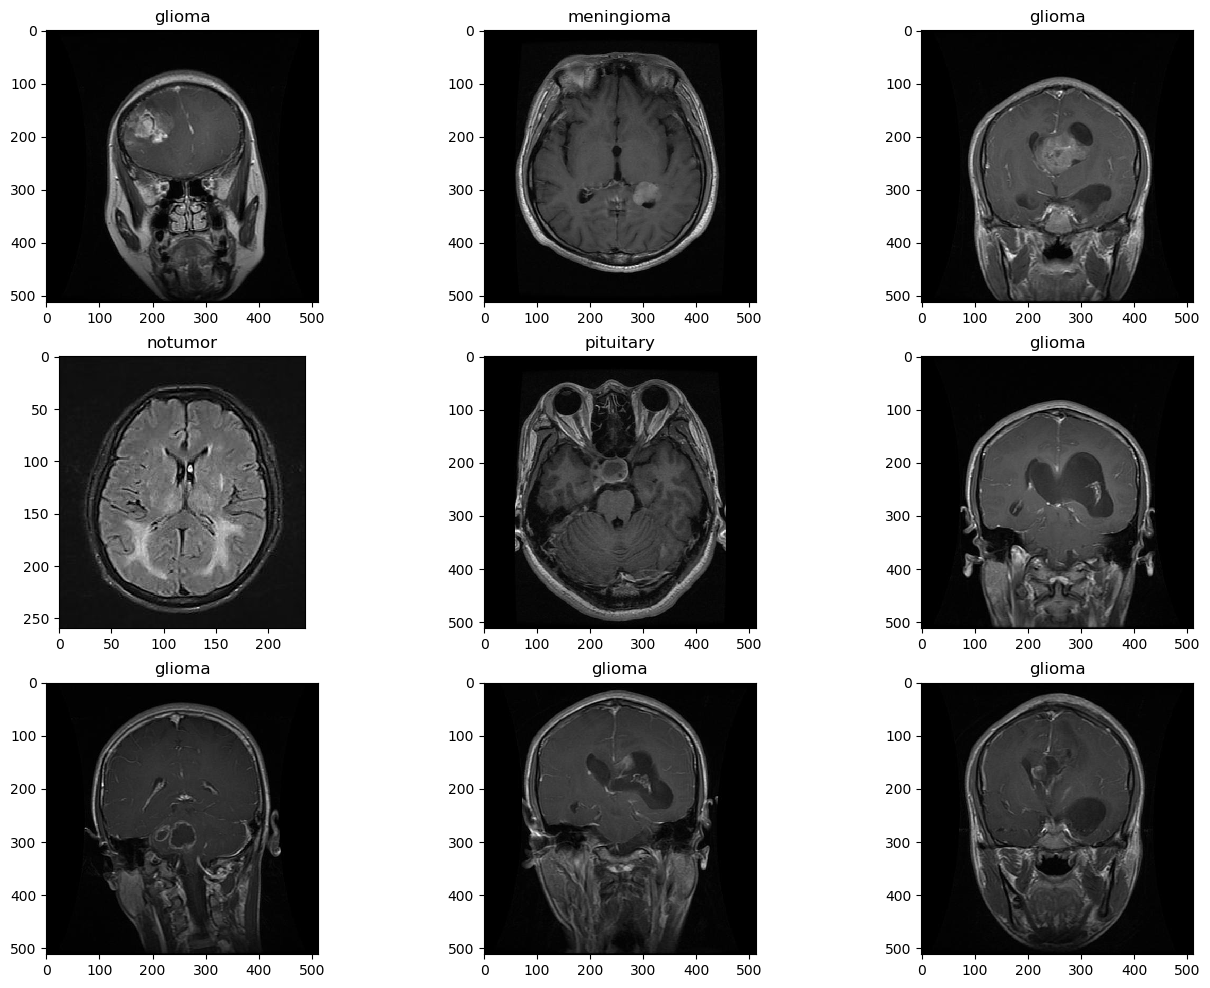

In [17]:
random_idx = [0,1323,1,2711,4500,2,3,4,5]
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[random_idx[idx]])
    ax.set_title(train_labels_list[random_idx[idx]])
    ax.imshow(img)

# Split

In [41]:
# Training settings
batch_size = 32
epochs = 100
lr = 7e-5
gamma = 0.7
seed = 326

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [12]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=train_labels_list,
                                          random_state=seed)

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 4569
Validation Data: 1143
Test Data: 1311


# Image Augmentation

In [14]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# train_transforms = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]
# )

# val_transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )


# test_transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )


# Load Datasets

In [18]:
class MRIDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)

        label = img_path.split("\\")[1]
        if label == "glioma":
            label = 0
        elif label =="meningioma":
            label = 1
        elif label == "notumor":
            label = 2
        elif label == "pituitary":
            label = 3

        return img_transformed, label


In [19]:
train_data = MRIDataset(train_list, transform=train_transforms)
valid_data = MRIDataset(valid_list, transform=test_transforms)
test_data = MRIDataset(test_list, transform=test_transforms)

In [20]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [21]:
print(len(train_data), len(train_loader))

4569 82


In [22]:
print(len(valid_data), len(valid_loader))

1143 21


In [23]:
print(len(test_data), len(test_loader))

1311 24


# Efficient Attention

### Linformer

In [34]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [35]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=4,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### SimpleViT

In [42]:
model = SimpleViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=4,
    channels=3,
    depth = 12,
    heads = 8,
    mlp_dim = 256
).to(device)

### Deep ViT

In [47]:
import torch
from vit_pytorch.deepvit import DeepViT

model = DeepViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 4,
    dim = 128,
    depth = 12,
    heads = 8,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

# Training

In [48]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# Plotting

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [30]:
def get_confusion_matrix(targets, outputs):
    labels = [0, 1, 2, 3]
    conf_matrix = confusion_matrix(y_true=targets, y_pred=outputs, labels=labels)
    return conf_matrix

In [31]:
def plot_confusion_matrix(conf_matrix,i):
    plt.imshow(X=conf_matrix, cmap=plt.cm.Greens)
    indices = range(conf_matrix.shape[0])
    labels = [0, 1, 2, 3]
    plt.xticks(ticks=indices, labels=labels)
    plt.yticks(ticks=indices, labels=labels)
    plt.colorbar()
    plt.xlabel('outputs')
    plt.ylabel('targets')
    plt.title('Confusion matrix of training'.format(i))
    for first_index in range(conf_matrix.shape[0]):
        for second_index in range(conf_matrix.shape[1]):
            plt.text(x=first_index, y=second_index, s=conf_matrix[first_index, second_index])
    #plt.savefig('heatmap_confusion_matrix.jpg')
    plt.show()

In [32]:
def plot_accuracies(train_acc,val_acc):
    accuracies = [acc.item() for acc in train_acc]
    val_accuracies = [acc.item() for acc in val_acc]
    plt.plot(accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(train_loss,val_loss):
    train_losses = [loss.item() for loss in train_loss]
    val_losses = [loss.item() for loss in val_loss]
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

### ViT (Linformer)

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.3134 - acc: 0.4090 - val_loss : 1.0130 - val_acc: 0.6025



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.9088 - acc: 0.6320 - val_loss : 0.8254 - val_acc: 0.6663



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7559 - acc: 0.7051 - val_loss : 0.7400 - val_acc: 0.7274



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6561 - acc: 0.7529 - val_loss : 0.6099 - val_acc: 0.7571



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5791 - acc: 0.7771 - val_loss : 0.5559 - val_acc: 0.7883



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.5167 - acc: 0.8086 - val_loss : 0.5819 - val_acc: 0.7723



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4987 - acc: 0.8107 - val_loss : 0.4635 - val_acc: 0.8296



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4339 - acc: 0.8301 - val_loss : 0.4561 - val_acc: 0.8221



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.4207 - acc: 0.8356 - val_loss : 0.3986 - val_acc: 0.8520



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3689 - acc: 0.8594 - val_loss : 0.4022 - val_acc: 0.8535



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3486 - acc: 0.8632 - val_loss : 0.3733 - val_acc: 0.8603



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3045 - acc: 0.8804 - val_loss : 0.3409 - val_acc: 0.8768



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.2821 - acc: 0.8941 - val_loss : 0.3495 - val_acc: 0.8615



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.2723 - acc: 0.9022 - val_loss : 0.3217 - val_acc: 0.8760



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.2413 - acc: 0.9103 - val_loss : 0.3434 - val_acc: 0.8735



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.2418 - acc: 0.9099 - val_loss : 0.2730 - val_acc: 0.8955



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.1945 - acc: 0.9330 - val_loss : 0.4229 - val_acc: 0.8469



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.1996 - acc: 0.9269 - val_loss : 0.2971 - val_acc: 0.8887



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.1769 - acc: 0.9375 - val_loss : 0.2970 - val_acc: 0.8931



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.1816 - acc: 0.9340 - val_loss : 0.3010 - val_acc: 0.8916



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.1500 - acc: 0.9505 - val_loss : 0.2873 - val_acc: 0.8892



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.1387 - acc: 0.9522 - val_loss : 0.2453 - val_acc: 0.9163



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.1296 - acc: 0.9593 - val_loss : 0.2856 - val_acc: 0.9116



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.1420 - acc: 0.9524 - val_loss : 0.2678 - val_acc: 0.9105



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.1282 - acc: 0.9548 - val_loss : 0.2440 - val_acc: 0.9210



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.1183 - acc: 0.9591 - val_loss : 0.2445 - val_acc: 0.9218



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.1134 - acc: 0.9617 - val_loss : 0.2753 - val_acc: 0.9129



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.1118 - acc: 0.9641 - val_loss : 0.2632 - val_acc: 0.9176



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.0996 - acc: 0.9667 - val_loss : 0.2492 - val_acc: 0.9205



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.0948 - acc: 0.9704 - val_loss : 0.3153 - val_acc: 0.8994



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.1023 - acc: 0.9652 - val_loss : 0.2492 - val_acc: 0.9253



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.0835 - acc: 0.9708 - val_loss : 0.2715 - val_acc: 0.9224



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.0796 - acc: 0.9715 - val_loss : 0.2243 - val_acc: 0.9376



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.0714 - acc: 0.9763 - val_loss : 0.2653 - val_acc: 0.9278



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.0673 - acc: 0.9781 - val_loss : 0.2490 - val_acc: 0.9308



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.0630 - acc: 0.9797 - val_loss : 0.2581 - val_acc: 0.9304



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.0657 - acc: 0.9800 - val_loss : 0.2431 - val_acc: 0.9355



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.0642 - acc: 0.9797 - val_loss : 0.2572 - val_acc: 0.9325



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.0498 - acc: 0.9835 - val_loss : 0.2770 - val_acc: 0.9359



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.0714 - acc: 0.9760 - val_loss : 0.3258 - val_acc: 0.9001



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.0615 - acc: 0.9818 - val_loss : 0.2865 - val_acc: 0.9260



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.0429 - acc: 0.9863 - val_loss : 0.2590 - val_acc: 0.9372



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.0471 - acc: 0.9854 - val_loss : 0.2764 - val_acc: 0.9300



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.0400 - acc: 0.9882 - val_loss : 0.2332 - val_acc: 0.9423



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.0369 - acc: 0.9889 - val_loss : 0.2802 - val_acc: 0.9328



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.0384 - acc: 0.9878 - val_loss : 0.2707 - val_acc: 0.9367



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.0420 - acc: 0.9867 - val_loss : 0.2236 - val_acc: 0.9422



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.0270 - acc: 0.9917 - val_loss : 0.2590 - val_acc: 0.9394



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.0411 - acc: 0.9887 - val_loss : 0.2938 - val_acc: 0.9292



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.0339 - acc: 0.9889 - val_loss : 0.2292 - val_acc: 0.9453



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.0282 - acc: 0.9903 - val_loss : 0.2400 - val_acc: 0.9363



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.0551 - acc: 0.9798 - val_loss : 0.2872 - val_acc: 0.9343



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.0252 - acc: 0.9932 - val_loss : 0.2499 - val_acc: 0.9478



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.0333 - acc: 0.9893 - val_loss : 0.2195 - val_acc: 0.9486



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.0236 - acc: 0.9939 - val_loss : 0.2858 - val_acc: 0.9389



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.0206 - acc: 0.9940 - val_loss : 0.2517 - val_acc: 0.9498



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.0233 - acc: 0.9916 - val_loss : 0.2692 - val_acc: 0.9381



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.0190 - acc: 0.9932 - val_loss : 0.2949 - val_acc: 0.9393



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.0394 - acc: 0.9872 - val_loss : 0.3140 - val_acc: 0.9333



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.0288 - acc: 0.9902 - val_loss : 0.3223 - val_acc: 0.9368



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.0263 - acc: 0.9928 - val_loss : 0.2466 - val_acc: 0.9452



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.0216 - acc: 0.9940 - val_loss : 0.2795 - val_acc: 0.9401



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.0209 - acc: 0.9941 - val_loss : 0.2599 - val_acc: 0.9342



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.0379 - acc: 0.9876 - val_loss : 0.2335 - val_acc: 0.9498



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.0307 - acc: 0.9896 - val_loss : 0.2493 - val_acc: 0.9439



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.0225 - acc: 0.9930 - val_loss : 0.2687 - val_acc: 0.9470



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.0167 - acc: 0.9946 - val_loss : 0.2546 - val_acc: 0.9461



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.0124 - acc: 0.9959 - val_loss : 0.2969 - val_acc: 0.9444



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.0272 - acc: 0.9915 - val_loss : 0.2446 - val_acc: 0.9503



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.0377 - acc: 0.9863 - val_loss : 0.3410 - val_acc: 0.9243



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.0242 - acc: 0.9917 - val_loss : 0.2779 - val_acc: 0.9411



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.0226 - acc: 0.9937 - val_loss : 0.2626 - val_acc: 0.9457



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.0113 - acc: 0.9963 - val_loss : 0.2700 - val_acc: 0.9486



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.0101 - acc: 0.9964 - val_loss : 0.3084 - val_acc: 0.9393



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.0110 - acc: 0.9970 - val_loss : 0.3038 - val_acc: 0.9435



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.0192 - acc: 0.9941 - val_loss : 0.2783 - val_acc: 0.9384



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.0081 - acc: 0.9978 - val_loss : 0.3089 - val_acc: 0.9415



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.0141 - acc: 0.9959 - val_loss : 0.2919 - val_acc: 0.9393



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.0116 - acc: 0.9967 - val_loss : 0.3002 - val_acc: 0.9389



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.0079 - acc: 0.9978 - val_loss : 0.2990 - val_acc: 0.9464



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.0044 - acc: 0.9991 - val_loss : 0.2991 - val_acc: 0.9465



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.0045 - acc: 0.9987 - val_loss : 0.3208 - val_acc: 0.9419



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.0061 - acc: 0.9980 - val_loss : 0.3110 - val_acc: 0.9436



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.0147 - acc: 0.9963 - val_loss : 0.3079 - val_acc: 0.9355



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.0349 - acc: 0.9885 - val_loss : 0.3405 - val_acc: 0.9367



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.0503 - acc: 0.9843 - val_loss : 0.2875 - val_acc: 0.9413



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.0313 - acc: 0.9891 - val_loss : 0.2818 - val_acc: 0.9453



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.0146 - acc: 0.9959 - val_loss : 0.2477 - val_acc: 0.9503



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.0172 - acc: 0.9948 - val_loss : 0.2622 - val_acc: 0.9478



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.0204 - acc: 0.9933 - val_loss : 0.2630 - val_acc: 0.9495



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.0157 - acc: 0.9954 - val_loss : 0.2611 - val_acc: 0.9435



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.0248 - acc: 0.9917 - val_loss : 0.2692 - val_acc: 0.9384



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.0145 - acc: 0.9956 - val_loss : 0.2603 - val_acc: 0.9498



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.0095 - acc: 0.9976 - val_loss : 0.2798 - val_acc: 0.9461



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.0058 - acc: 0.9983 - val_loss : 0.2788 - val_acc: 0.9503



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.0050 - acc: 0.9983 - val_loss : 0.2806 - val_acc: 0.9482



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.0032 - acc: 0.9991 - val_loss : 0.3316 - val_acc: 0.9469



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.0144 - acc: 0.9961 - val_loss : 0.2870 - val_acc: 0.9444



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.0092 - acc: 0.9974 - val_loss : 0.2829 - val_acc: 0.9448



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.0058 - acc: 0.9980 - val_loss : 0.2629 - val_acc: 0.9512

Epoch:99
Loss value in the last epoch of training is:0.005795577075332403
Accuracy in the last epoch of training is:0.9980394840240479
Accuracy of training:0.9541956664478004
Precision of training:0.9541956664478004
Recall of training:0.9541956664478004
Micro f1 score of training:0.9541956664478004
Classification report of training:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    105700
           1       0.93      0.92      0.92    107100
           2       0.97      0.98      0.97    127600
           3       0.97      0.98      0.97    116500

    accuracy                           0.95    456900
   macro avg       0.95      0.95      0.95    456900
weighted avg       0.95      0.95      0.95    456900

Confusion matrix of training:
[[ 98699   5461    516   1024]
 [  4269  98126   2750   1955]
 [   602   1045 124985    968]
 [   624    930    784 114

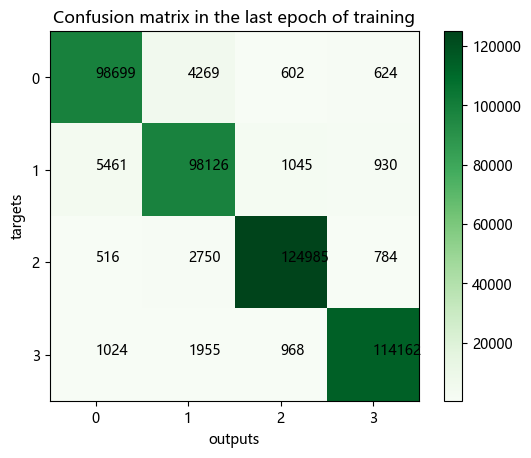

Loss value in the last epoch of validation is:0.26287439465522766
Accuracy in the last epoch of validation is:0.9511609673500061
Accuracy of validation:0.9134820647419073
Precision of validation:0.9134820647419073
Recall of validation:0.9134820647419073
Micro f1 score of validation:0.9134820647419073
Classification report of validation:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     26400
           1       0.84      0.85      0.84     26800
           2       0.94      0.96      0.95     31900
           3       0.96      0.98      0.97     29200

    accuracy                           0.91    114300
   macro avg       0.91      0.91      0.91    114300
weighted avg       0.91      0.91      0.91    114300

Confusion matrix of validation:
[[22442  3512    50   396]
 [ 1750 22708  1813   529]
 [  375   558 30553   414]
 [  122   271    99 28708]]


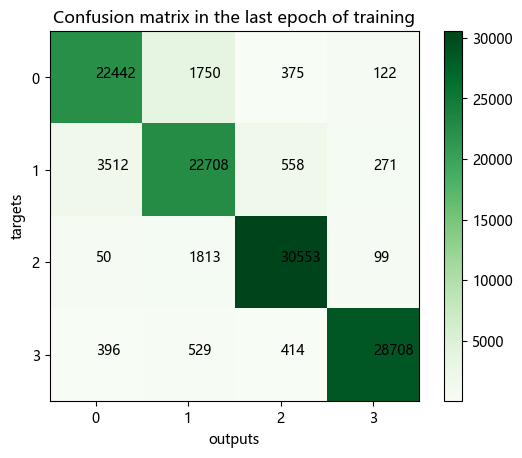

In [92]:
train_loss = []
train_acc = []
val_loss_list = []
val_acc_list = []
outputs_train = []
outputs_val = []
targets_train = []
targets_val = []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        outputs_train.extend(item.cpu().detach().numpy() for item in output.argmax(1))
        targets_train.extend(item.cpu().detach().numpy() for item in label)
        
    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            
            outputs_val.extend(item.cpu().detach().numpy() for item in val_output.argmax(1))
            targets_val.extend(item.cpu().detach().numpy() for item in label)
            
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

######################################################################################################################################    
print("Epoch:{}".format(epoch))
print("Loss value in the last epoch of training is:{}".format(epoch_loss))
print("Accuracy in the last epoch of training is:{}".format(epoch_accuracy))

sklearn_accuracy1 = accuracy_score(targets_train, outputs_train)
sklearn_precision1 = precision_score(targets_train, outputs_train, average='micro')
sklearn_recall1 = recall_score(targets_train, outputs_train, average='micro')
sklearn_f11 = f1_score(targets_train, outputs_train, average='micro')
print("Accuracy of training:{}".format(sklearn_accuracy1))
print("Precision of training:{}".format(sklearn_precision1))
print("Recall of training:{}".format(sklearn_recall1))
print("Micro f1 score of training:{}".format(sklearn_f11))

sklearn_report1 = classification_report(targets_train, outputs_train)
print("Classification report of training:")
print(sklearn_report1)

conf_matrix1 = get_confusion_matrix(targets_train, outputs_train)
print("Confusion matrix of training:")
print(conf_matrix1)
plot_confusion_matrix(conf_matrix1,epoch)

#####################################################################################################################################
print("Loss value in the last epoch of validation is:{}".format(epoch_val_loss))
print("Accuracy in the last epoch of validation is:{}".format(epoch_val_accuracy))

sklearn_accuracy2 = accuracy_score(targets_val, outputs_val)
sklearn_precision2 = precision_score(targets_val, outputs_val, average='micro')
sklearn_recall2 = recall_score(targets_val, outputs_val, average='micro')
sklearn_f12 = f1_score(targets_val, outputs_val, average='micro')
print("Accuracy of validation:{}".format(sklearn_accuracy2))
print("Precision of validation:{}".format(sklearn_precision2))
print("Recall of validation:{}".format(sklearn_recall2))
print("Micro f1 score of validation:{}".format(sklearn_f12))

sklearn_report2 = classification_report(targets_val, outputs_val)
print("Classification report of validation:")
print(sklearn_report2)

conf_matrix2 = get_confusion_matrix(targets_val, outputs_val)
print("Confusion matrix of validation:")
print(conf_matrix2)
plot_confusion_matrix(conf_matrix2,epoch)


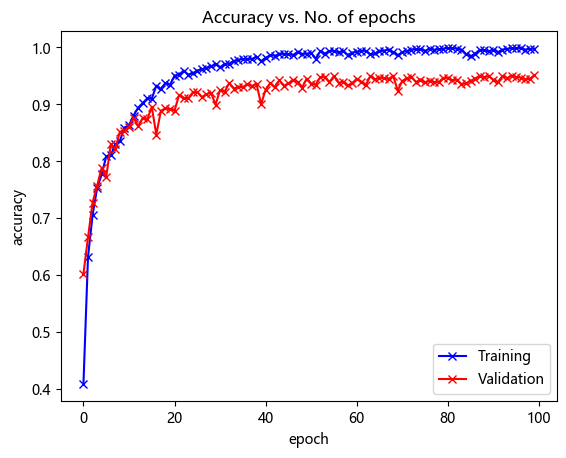

In [94]:
plot_accuracies(train_acc,val_acc_list)

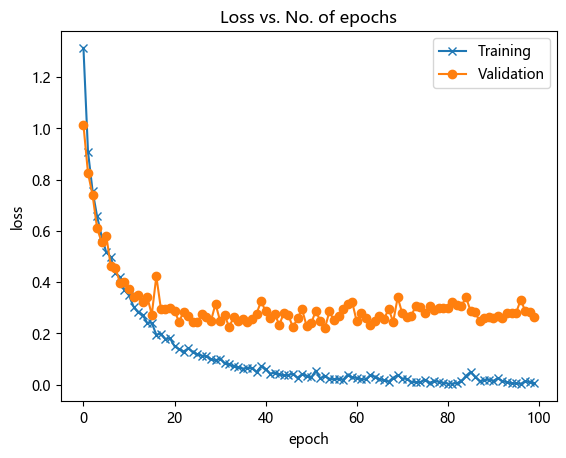

In [95]:
plot_losses(train_loss,val_loss_list)

### ViT (Linformer) (Image Augmentation 2)

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.1405 - acc: 0.5188 - val_loss : 0.9228 - val_acc: 0.6590



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8861 - acc: 0.6534 - val_loss : 0.8248 - val_acc: 0.6951



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8287 - acc: 0.6847 - val_loss : 0.7751 - val_acc: 0.6915



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7608 - acc: 0.7120 - val_loss : 0.7121 - val_acc: 0.7281



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7231 - acc: 0.7304 - val_loss : 0.7020 - val_acc: 0.7338



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6855 - acc: 0.7458 - val_loss : 0.6395 - val_acc: 0.7590



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6985 - acc: 0.7350 - val_loss : 0.6734 - val_acc: 0.7486



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6589 - acc: 0.7502 - val_loss : 0.6263 - val_acc: 0.7553



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6214 - acc: 0.7688 - val_loss : 0.5633 - val_acc: 0.7778



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5520 - acc: 0.7925 - val_loss : 0.5588 - val_acc: 0.7869



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5506 - acc: 0.7966 - val_loss : 0.5045 - val_acc: 0.8080



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.4925 - acc: 0.8135 - val_loss : 0.5206 - val_acc: 0.7941



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.4927 - acc: 0.8172 - val_loss : 0.4981 - val_acc: 0.8101



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.4699 - acc: 0.8244 - val_loss : 0.4496 - val_acc: 0.8305



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.4217 - acc: 0.8434 - val_loss : 0.4168 - val_acc: 0.8389



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3853 - acc: 0.8568 - val_loss : 0.4128 - val_acc: 0.8394



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.4092 - acc: 0.8395 - val_loss : 0.3900 - val_acc: 0.8560



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3677 - acc: 0.8597 - val_loss : 0.3545 - val_acc: 0.8584



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3491 - acc: 0.8653 - val_loss : 0.3500 - val_acc: 0.8644



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3304 - acc: 0.8722 - val_loss : 0.3189 - val_acc: 0.8751



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.3193 - acc: 0.8759 - val_loss : 0.3501 - val_acc: 0.8709



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.3241 - acc: 0.8781 - val_loss : 0.3274 - val_acc: 0.8696



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.2906 - acc: 0.8910 - val_loss : 0.2877 - val_acc: 0.8967



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.2835 - acc: 0.8946 - val_loss : 0.3478 - val_acc: 0.8599



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.2702 - acc: 0.8967 - val_loss : 0.2943 - val_acc: 0.8934



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.2584 - acc: 0.9034 - val_loss : 0.3180 - val_acc: 0.8658



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.2575 - acc: 0.9065 - val_loss : 0.3027 - val_acc: 0.8837



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.2362 - acc: 0.9098 - val_loss : 0.2703 - val_acc: 0.9102



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.2376 - acc: 0.9166 - val_loss : 0.3591 - val_acc: 0.8662



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.2395 - acc: 0.9069 - val_loss : 0.2859 - val_acc: 0.8967



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.2247 - acc: 0.9178 - val_loss : 0.2651 - val_acc: 0.9044



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.1923 - acc: 0.9286 - val_loss : 0.2568 - val_acc: 0.9006



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.2088 - acc: 0.9241 - val_loss : 0.2777 - val_acc: 0.8942



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.2014 - acc: 0.9266 - val_loss : 0.2609 - val_acc: 0.9056



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.1616 - acc: 0.9413 - val_loss : 0.2678 - val_acc: 0.9125



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.1736 - acc: 0.9358 - val_loss : 0.2499 - val_acc: 0.9134



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.1630 - acc: 0.9415 - val_loss : 0.2470 - val_acc: 0.9180



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.1527 - acc: 0.9429 - val_loss : 0.2859 - val_acc: 0.9017



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.1681 - acc: 0.9403 - val_loss : 0.2441 - val_acc: 0.9202



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.1478 - acc: 0.9463 - val_loss : 0.3210 - val_acc: 0.8807



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.1467 - acc: 0.9461 - val_loss : 0.2023 - val_acc: 0.9274



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.1354 - acc: 0.9475 - val_loss : 0.2656 - val_acc: 0.9045



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.1363 - acc: 0.9536 - val_loss : 0.2313 - val_acc: 0.9231



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.1372 - acc: 0.9497 - val_loss : 0.2034 - val_acc: 0.9205



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.1379 - acc: 0.9487 - val_loss : 0.2248 - val_acc: 0.9197



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.1233 - acc: 0.9567 - val_loss : 0.2045 - val_acc: 0.9308



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.1088 - acc: 0.9572 - val_loss : 0.2120 - val_acc: 0.9286



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.1226 - acc: 0.9591 - val_loss : 0.2059 - val_acc: 0.9346



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.1273 - acc: 0.9542 - val_loss : 0.2700 - val_acc: 0.9120



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.1175 - acc: 0.9559 - val_loss : 0.2376 - val_acc: 0.9286



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.1020 - acc: 0.9627 - val_loss : 0.2000 - val_acc: 0.9351



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.1133 - acc: 0.9567 - val_loss : 0.2551 - val_acc: 0.9125



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.1067 - acc: 0.9638 - val_loss : 0.1919 - val_acc: 0.9406



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.0858 - acc: 0.9718 - val_loss : 0.1754 - val_acc: 0.9473



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.0968 - acc: 0.9633 - val_loss : 0.2384 - val_acc: 0.9215



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.0795 - acc: 0.9723 - val_loss : 0.1828 - val_acc: 0.9422



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.1021 - acc: 0.9637 - val_loss : 0.2024 - val_acc: 0.9295



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.1060 - acc: 0.9643 - val_loss : 0.1987 - val_acc: 0.9338



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.0831 - acc: 0.9699 - val_loss : 0.2007 - val_acc: 0.9338



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.1048 - acc: 0.9635 - val_loss : 0.1949 - val_acc: 0.9384



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.0695 - acc: 0.9765 - val_loss : 0.2355 - val_acc: 0.9278



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.0680 - acc: 0.9763 - val_loss : 0.1503 - val_acc: 0.9575



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.0658 - acc: 0.9768 - val_loss : 0.1812 - val_acc: 0.9512



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.0828 - acc: 0.9715 - val_loss : 0.1799 - val_acc: 0.9447



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.0711 - acc: 0.9761 - val_loss : 0.1993 - val_acc: 0.9481



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.0706 - acc: 0.9745 - val_loss : 0.1810 - val_acc: 0.9495



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.0687 - acc: 0.9747 - val_loss : 0.1468 - val_acc: 0.9583



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.0529 - acc: 0.9818 - val_loss : 0.1874 - val_acc: 0.9406



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.0597 - acc: 0.9789 - val_loss : 0.1787 - val_acc: 0.9481



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.0630 - acc: 0.9763 - val_loss : 0.2366 - val_acc: 0.9278



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.0629 - acc: 0.9790 - val_loss : 0.2083 - val_acc: 0.9401



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.0577 - acc: 0.9800 - val_loss : 0.2034 - val_acc: 0.9346



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.0563 - acc: 0.9797 - val_loss : 0.1757 - val_acc: 0.9495



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.0500 - acc: 0.9839 - val_loss : 0.1492 - val_acc: 0.9549



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.0461 - acc: 0.9845 - val_loss : 0.1925 - val_acc: 0.9464



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.0544 - acc: 0.9791 - val_loss : 0.1966 - val_acc: 0.9384



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.0526 - acc: 0.9819 - val_loss : 0.2007 - val_acc: 0.9422



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.0493 - acc: 0.9813 - val_loss : 0.2110 - val_acc: 0.9362



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.0590 - acc: 0.9805 - val_loss : 0.2178 - val_acc: 0.9367



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.0466 - acc: 0.9835 - val_loss : 0.1707 - val_acc: 0.9546



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.0691 - acc: 0.9761 - val_loss : 0.2320 - val_acc: 0.9380



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.0655 - acc: 0.9778 - val_loss : 0.1896 - val_acc: 0.9456



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.0291 - acc: 0.9906 - val_loss : 0.1964 - val_acc: 0.9487



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.0407 - acc: 0.9869 - val_loss : 0.1639 - val_acc: 0.9512



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.0415 - acc: 0.9861 - val_loss : 0.1822 - val_acc: 0.9507



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.0483 - acc: 0.9811 - val_loss : 0.1418 - val_acc: 0.9634



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.0423 - acc: 0.9847 - val_loss : 0.2068 - val_acc: 0.9410



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.0424 - acc: 0.9861 - val_loss : 0.1636 - val_acc: 0.9512



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.0274 - acc: 0.9913 - val_loss : 0.1833 - val_acc: 0.9525



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.0377 - acc: 0.9863 - val_loss : 0.2205 - val_acc: 0.9474



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.0359 - acc: 0.9882 - val_loss : 0.2087 - val_acc: 0.9490



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.0416 - acc: 0.9862 - val_loss : 0.2020 - val_acc: 0.9491



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.0489 - acc: 0.9826 - val_loss : 0.1946 - val_acc: 0.9464



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.0416 - acc: 0.9852 - val_loss : 0.1877 - val_acc: 0.9515



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.0436 - acc: 0.9844 - val_loss : 0.2310 - val_acc: 0.9464



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.0535 - acc: 0.9811 - val_loss : 0.1567 - val_acc: 0.9554



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.0420 - acc: 0.9861 - val_loss : 0.1576 - val_acc: 0.9571



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.0243 - acc: 0.9922 - val_loss : 0.1815 - val_acc: 0.9533



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.0335 - acc: 0.9889 - val_loss : 0.1780 - val_acc: 0.9516



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.0336 - acc: 0.9885 - val_loss : 0.1628 - val_acc: 0.9575

Epoch:99
Loss value in the last epoch of training is:0.033644113689661026
Accuracy in the last epoch of training is:0.9884579181671143
Accuracy of training:0.9227139417815715
Precision of training:0.9227139417815715
Recall of training:0.9227139417815715
Micro f1 score of training:0.9227139417815715
Classification report of training:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91    105700
           1       0.88      0.86      0.87    107100
           2       0.95      0.96      0.95    127600
           3       0.94      0.96      0.95    116500

    accuracy                           0.92    456900
   macro avg       0.92      0.92      0.92    456900
weighted avg       0.92      0.92      0.92    456900

Confusion matrix of training:
[[ 95567   7631    551   1951]
 [  6239  92413   4761   3687]
 [  1230   2440 122313   1617]
 [  1445   2492   1268 111

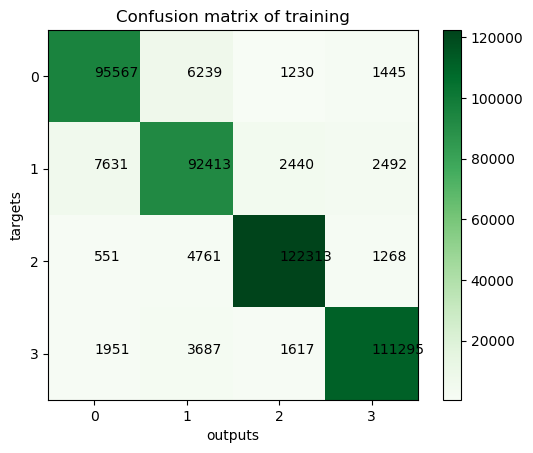

Loss value in the last epoch of validation is:0.16279816627502441
Accuracy in the last epoch of validation is:0.9574830532073975
Accuracy of validation:0.8999562554680665
Precision of validation:0.8999562554680665
Recall of validation:0.8999562554680665
Micro f1 score of validation:0.8999562554680665
Classification report of validation:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     26400
           1       0.83      0.82      0.82     26800
           2       0.93      0.94      0.93     31900
           3       0.94      0.97      0.95     29200

    accuracy                           0.90    114300
   macro avg       0.90      0.90      0.90    114300
weighted avg       0.90      0.90      0.90    114300

Confusion matrix of validation:
[[22912  2940   106   442]
 [ 2166 21893  1922   819]
 [  410  1075 29878   537]
 [  261   547   210 28182]]


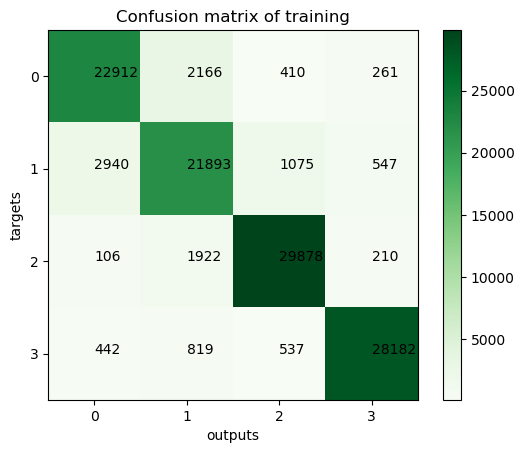

In [38]:
train_loss = []
train_acc = []
val_loss_list = []
val_acc_list = []
outputs_train = []
outputs_val = []
targets_train = []
targets_val = []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        outputs_train.extend(item.cpu().detach().numpy() for item in output.argmax(1))
        targets_train.extend(item.cpu().detach().numpy() for item in label)
        
    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            
            outputs_val.extend(item.cpu().detach().numpy() for item in val_output.argmax(1))
            targets_val.extend(item.cpu().detach().numpy() for item in label)
            
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

######################################################################################################################################    
print("Epoch:{}".format(epoch))
print("Loss value in the last epoch of training is:{}".format(epoch_loss))
print("Accuracy in the last epoch of training is:{}".format(epoch_accuracy))

sklearn_accuracy1 = accuracy_score(targets_train, outputs_train)
sklearn_precision1 = precision_score(targets_train, outputs_train, average='micro')
sklearn_recall1 = recall_score(targets_train, outputs_train, average='micro')
sklearn_f11 = f1_score(targets_train, outputs_train, average='micro')
print("Accuracy of training:{}".format(sklearn_accuracy1))
print("Precision of training:{}".format(sklearn_precision1))
print("Recall of training:{}".format(sklearn_recall1))
print("Micro f1 score of training:{}".format(sklearn_f11))

sklearn_report1 = classification_report(targets_train, outputs_train)
print("Classification report of training:")
print(sklearn_report1)

conf_matrix1 = get_confusion_matrix(targets_train, outputs_train)
print("Confusion matrix of training:")
print(conf_matrix1)
plot_confusion_matrix(conf_matrix1,epoch)

#####################################################################################################################################
print("Loss value in the last epoch of validation is:{}".format(epoch_val_loss))
print("Accuracy in the last epoch of validation is:{}".format(epoch_val_accuracy))

sklearn_accuracy2 = accuracy_score(targets_val, outputs_val)
sklearn_precision2 = precision_score(targets_val, outputs_val, average='micro')
sklearn_recall2 = recall_score(targets_val, outputs_val, average='micro')
sklearn_f12 = f1_score(targets_val, outputs_val, average='micro')
print("Accuracy of validation:{}".format(sklearn_accuracy2))
print("Precision of validation:{}".format(sklearn_precision2))
print("Recall of validation:{}".format(sklearn_recall2))
print("Micro f1 score of validation:{}".format(sklearn_f12))

sklearn_report2 = classification_report(targets_val, outputs_val)
print("Classification report of validation:")
print(sklearn_report2)

conf_matrix2 = get_confusion_matrix(targets_val, outputs_val)
print("Confusion matrix of validation:")
print(conf_matrix2)
plot_confusion_matrix(conf_matrix2,epoch)


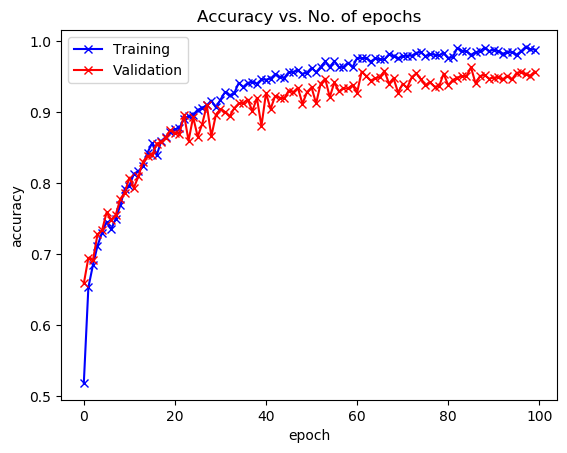

In [39]:
plot_accuracies(train_acc,val_acc_list)

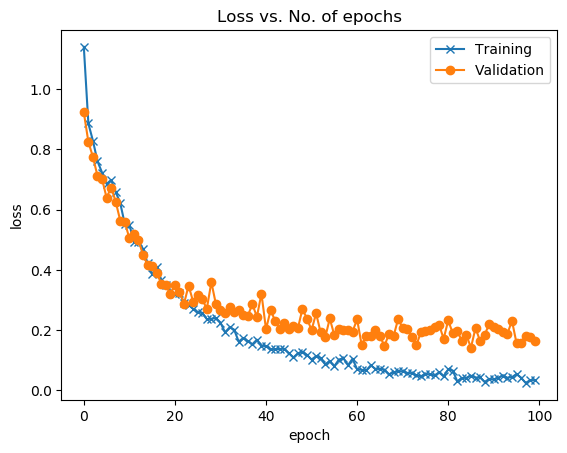

In [40]:
plot_losses(train_loss,val_loss_list)

### Simple ViT

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.1629 - acc: 0.4863 - val_loss : 0.9501 - val_acc: 0.6235



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8986 - acc: 0.6477 - val_loss : 0.8462 - val_acc: 0.6648



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8004 - acc: 0.7021 - val_loss : 0.7507 - val_acc: 0.7090



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7579 - acc: 0.7091 - val_loss : 0.7519 - val_acc: 0.7150



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7462 - acc: 0.7183 - val_loss : 0.6629 - val_acc: 0.7514



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6983 - acc: 0.7379 - val_loss : 0.6360 - val_acc: 0.7534



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6597 - acc: 0.7500 - val_loss : 0.6510 - val_acc: 0.7513



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6272 - acc: 0.7657 - val_loss : 0.5971 - val_acc: 0.7595



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6057 - acc: 0.7712 - val_loss : 0.5723 - val_acc: 0.7767



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5607 - acc: 0.7924 - val_loss : 0.5446 - val_acc: 0.7936



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5243 - acc: 0.8003 - val_loss : 0.5114 - val_acc: 0.8009



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5081 - acc: 0.8140 - val_loss : 0.5073 - val_acc: 0.8010



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.4776 - acc: 0.8176 - val_loss : 0.4806 - val_acc: 0.8102



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.4797 - acc: 0.8199 - val_loss : 0.4493 - val_acc: 0.8314



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.4503 - acc: 0.8242 - val_loss : 0.4576 - val_acc: 0.8227



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.4139 - acc: 0.8492 - val_loss : 0.4536 - val_acc: 0.8429



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.4228 - acc: 0.8373 - val_loss : 0.4106 - val_acc: 0.8483



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3937 - acc: 0.8490 - val_loss : 0.3973 - val_acc: 0.8530



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3737 - acc: 0.8584 - val_loss : 0.3862 - val_acc: 0.8497



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3540 - acc: 0.8610 - val_loss : 0.3658 - val_acc: 0.8560



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.3514 - acc: 0.8657 - val_loss : 0.3935 - val_acc: 0.8522



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.3310 - acc: 0.8705 - val_loss : 0.3548 - val_acc: 0.8710



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.3314 - acc: 0.8693 - val_loss : 0.3900 - val_acc: 0.8560



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.3278 - acc: 0.8785 - val_loss : 0.3578 - val_acc: 0.8590



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.3014 - acc: 0.8851 - val_loss : 0.3630 - val_acc: 0.8611



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.2974 - acc: 0.8864 - val_loss : 0.3349 - val_acc: 0.8760



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.3055 - acc: 0.8830 - val_loss : 0.3450 - val_acc: 0.8676



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.2774 - acc: 0.8957 - val_loss : 0.3435 - val_acc: 0.8756



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.2741 - acc: 0.8947 - val_loss : 0.3277 - val_acc: 0.8796



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.2669 - acc: 0.8990 - val_loss : 0.3940 - val_acc: 0.8548



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.2557 - acc: 0.9019 - val_loss : 0.3015 - val_acc: 0.8900



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.2418 - acc: 0.9063 - val_loss : 0.2986 - val_acc: 0.8885



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.2299 - acc: 0.9159 - val_loss : 0.3074 - val_acc: 0.8832



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.2233 - acc: 0.9176 - val_loss : 0.3429 - val_acc: 0.8757



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.2281 - acc: 0.9125 - val_loss : 0.2842 - val_acc: 0.8961



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.2256 - acc: 0.9156 - val_loss : 0.2942 - val_acc: 0.8994



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.2311 - acc: 0.9141 - val_loss : 0.2735 - val_acc: 0.9074



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.1998 - acc: 0.9257 - val_loss : 0.2947 - val_acc: 0.8950



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.2178 - acc: 0.9191 - val_loss : 0.3200 - val_acc: 0.8837



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.1915 - acc: 0.9310 - val_loss : 0.2773 - val_acc: 0.9018



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.1937 - acc: 0.9271 - val_loss : 0.2666 - val_acc: 0.8943



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.1803 - acc: 0.9318 - val_loss : 0.2923 - val_acc: 0.8967



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.1747 - acc: 0.9393 - val_loss : 0.2330 - val_acc: 0.9134



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.1677 - acc: 0.9376 - val_loss : 0.2564 - val_acc: 0.9045



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.1807 - acc: 0.9329 - val_loss : 0.3442 - val_acc: 0.8768



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.1590 - acc: 0.9419 - val_loss : 0.2492 - val_acc: 0.9083



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.1734 - acc: 0.9341 - val_loss : 0.2310 - val_acc: 0.9193



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.1575 - acc: 0.9401 - val_loss : 0.2582 - val_acc: 0.9074



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.1597 - acc: 0.9389 - val_loss : 0.2037 - val_acc: 0.9295



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.1406 - acc: 0.9507 - val_loss : 0.2451 - val_acc: 0.9146



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.1341 - acc: 0.9503 - val_loss : 0.2206 - val_acc: 0.9248



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.1302 - acc: 0.9506 - val_loss : 0.2123 - val_acc: 0.9270



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.1284 - acc: 0.9527 - val_loss : 0.2170 - val_acc: 0.9193



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.1236 - acc: 0.9565 - val_loss : 0.2344 - val_acc: 0.9158



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.1223 - acc: 0.9564 - val_loss : 0.2166 - val_acc: 0.9304



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.1284 - acc: 0.9559 - val_loss : 0.2101 - val_acc: 0.9384



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.1199 - acc: 0.9596 - val_loss : 0.2178 - val_acc: 0.9296



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.1271 - acc: 0.9559 - val_loss : 0.2017 - val_acc: 0.9282



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.1029 - acc: 0.9602 - val_loss : 0.2208 - val_acc: 0.9360



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.1056 - acc: 0.9628 - val_loss : 0.1934 - val_acc: 0.9389



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.0981 - acc: 0.9650 - val_loss : 0.1919 - val_acc: 0.9396



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.1003 - acc: 0.9635 - val_loss : 0.2192 - val_acc: 0.9316



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.1025 - acc: 0.9617 - val_loss : 0.2314 - val_acc: 0.9261



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.0917 - acc: 0.9676 - val_loss : 0.1744 - val_acc: 0.9410



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.1171 - acc: 0.9593 - val_loss : 0.2014 - val_acc: 0.9291



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.0963 - acc: 0.9634 - val_loss : 0.1695 - val_acc: 0.9444



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.0905 - acc: 0.9654 - val_loss : 0.2176 - val_acc: 0.9278



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.0706 - acc: 0.9758 - val_loss : 0.1829 - val_acc: 0.9507



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.0803 - acc: 0.9714 - val_loss : 0.1872 - val_acc: 0.9508



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.0764 - acc: 0.9702 - val_loss : 0.1786 - val_acc: 0.9498



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.0773 - acc: 0.9736 - val_loss : 0.1715 - val_acc: 0.9436



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.0806 - acc: 0.9726 - val_loss : 0.1928 - val_acc: 0.9338



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.0662 - acc: 0.9776 - val_loss : 0.2467 - val_acc: 0.9295



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.0909 - acc: 0.9677 - val_loss : 0.1705 - val_acc: 0.9529



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.0651 - acc: 0.9790 - val_loss : 0.1938 - val_acc: 0.9482



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.0901 - acc: 0.9692 - val_loss : 0.1896 - val_acc: 0.9389



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.0736 - acc: 0.9739 - val_loss : 0.1733 - val_acc: 0.9524



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.0558 - acc: 0.9813 - val_loss : 0.2025 - val_acc: 0.9410



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.0704 - acc: 0.9758 - val_loss : 0.1725 - val_acc: 0.9457



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.0546 - acc: 0.9813 - val_loss : 0.1453 - val_acc: 0.9530



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.0716 - acc: 0.9767 - val_loss : 0.1877 - val_acc: 0.9456



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.0729 - acc: 0.9744 - val_loss : 0.1826 - val_acc: 0.9520



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.0806 - acc: 0.9733 - val_loss : 0.2037 - val_acc: 0.9461



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.0729 - acc: 0.9742 - val_loss : 0.1778 - val_acc: 0.9457



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.0510 - acc: 0.9844 - val_loss : 0.1898 - val_acc: 0.9486



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.0606 - acc: 0.9794 - val_loss : 0.1995 - val_acc: 0.9516



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.0674 - acc: 0.9746 - val_loss : 0.1984 - val_acc: 0.9368



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.0547 - acc: 0.9790 - val_loss : 0.2398 - val_acc: 0.9363



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.0507 - acc: 0.9814 - val_loss : 0.1895 - val_acc: 0.9461



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.0613 - acc: 0.9796 - val_loss : 0.2281 - val_acc: 0.9224



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.0696 - acc: 0.9744 - val_loss : 0.2429 - val_acc: 0.9291



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.0446 - acc: 0.9845 - val_loss : 0.2048 - val_acc: 0.9430



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.0657 - acc: 0.9770 - val_loss : 0.1752 - val_acc: 0.9490



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.0737 - acc: 0.9723 - val_loss : 0.1740 - val_acc: 0.9456



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.0558 - acc: 0.9795 - val_loss : 0.1745 - val_acc: 0.9566



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.0302 - acc: 0.9904 - val_loss : 0.1823 - val_acc: 0.9549



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.0386 - acc: 0.9852 - val_loss : 0.1696 - val_acc: 0.9512



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.0513 - acc: 0.9832 - val_loss : 0.2595 - val_acc: 0.9295



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.0348 - acc: 0.9865 - val_loss : 0.2252 - val_acc: 0.9431



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.0708 - acc: 0.9726 - val_loss : 0.1830 - val_acc: 0.9515

Epoch:99
Loss value in the last epoch of training is:0.07083381712436676
Accuracy in the last epoch of training is:0.9726266264915466
Accuracy of training:0.9132611074633399
Precision of training:0.9132611074633399
Recall of training:0.9132611074633399
Micro f1 score of training:0.9132611074633399
Classification report of training:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89    105700
           1       0.86      0.85      0.85    107100
           2       0.95      0.96      0.95    127600
           3       0.93      0.95      0.94    116500

    accuracy                           0.91    456900
   macro avg       0.91      0.91      0.91    456900
weighted avg       0.91      0.91      0.91    456900

Confusion matrix of training:
[[ 93552   9284    619   2245]
 [  7415  90781   4894   4010]
 [  1282   2479 122088   1751]
 [  1585   2762   1305 1108

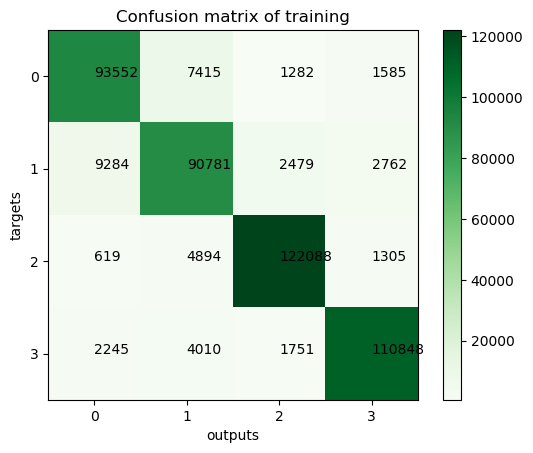

Loss value in the last epoch of validation is:0.1829896718263626
Accuracy in the last epoch of validation is:0.9515306949615479
Accuracy of validation:0.8926071741032371
Precision of validation:0.8926071741032371
Recall of validation:0.8926071741032371
Micro f1 score of validation:0.8926071741032371
Classification report of validation:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     26400
           1       0.82      0.80      0.81     26800
           2       0.93      0.93      0.93     31900
           3       0.93      0.97      0.95     29200

    accuracy                           0.89    114300
   macro avg       0.89      0.89      0.89    114300
weighted avg       0.89      0.89      0.89    114300

Confusion matrix of validation:
[[22511  3265   204   420]
 [ 2258 21537  1892  1113]
 [  384  1047 29747   722]
 [  272   486   212 28230]]


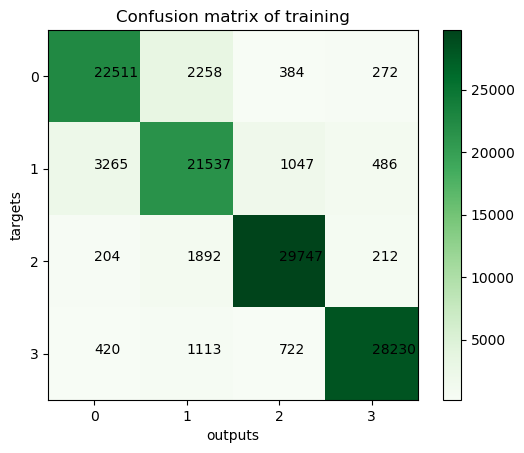

In [44]:
train_loss = []
train_acc = []
val_loss_list = []
val_acc_list = []
outputs_train = []
outputs_val = []
targets_train = []
targets_val = []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        outputs_train.extend(item.cpu().detach().numpy() for item in output.argmax(1))
        targets_train.extend(item.cpu().detach().numpy() for item in label)
        
    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            
            outputs_val.extend(item.cpu().detach().numpy() for item in val_output.argmax(1))
            targets_val.extend(item.cpu().detach().numpy() for item in label)
            
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

######################################################################################################################################    
print("Epoch:{}".format(epoch))
print("Loss value in the last epoch of training is:{}".format(epoch_loss))
print("Accuracy in the last epoch of training is:{}".format(epoch_accuracy))

sklearn_accuracy1 = accuracy_score(targets_train, outputs_train)
sklearn_precision1 = precision_score(targets_train, outputs_train, average='micro')
sklearn_recall1 = recall_score(targets_train, outputs_train, average='micro')
sklearn_f11 = f1_score(targets_train, outputs_train, average='micro')
print("Accuracy of training:{}".format(sklearn_accuracy1))
print("Precision of training:{}".format(sklearn_precision1))
print("Recall of training:{}".format(sklearn_recall1))
print("Micro f1 score of training:{}".format(sklearn_f11))

sklearn_report1 = classification_report(targets_train, outputs_train)
print("Classification report of training:")
print(sklearn_report1)

conf_matrix1 = get_confusion_matrix(targets_train, outputs_train)
print("Confusion matrix of training:")
print(conf_matrix1)
plot_confusion_matrix(conf_matrix1,epoch)

#####################################################################################################################################
print("Loss value in the last epoch of validation is:{}".format(epoch_val_loss))
print("Accuracy in the last epoch of validation is:{}".format(epoch_val_accuracy))

sklearn_accuracy2 = accuracy_score(targets_val, outputs_val)
sklearn_precision2 = precision_score(targets_val, outputs_val, average='micro')
sklearn_recall2 = recall_score(targets_val, outputs_val, average='micro')
sklearn_f12 = f1_score(targets_val, outputs_val, average='micro')
print("Accuracy of validation:{}".format(sklearn_accuracy2))
print("Precision of validation:{}".format(sklearn_precision2))
print("Recall of validation:{}".format(sklearn_recall2))
print("Micro f1 score of validation:{}".format(sklearn_f12))

sklearn_report2 = classification_report(targets_val, outputs_val)
print("Classification report of validation:")
print(sklearn_report2)

conf_matrix2 = get_confusion_matrix(targets_val, outputs_val)
print("Confusion matrix of validation:")
print(conf_matrix2)
plot_confusion_matrix(conf_matrix2,epoch)


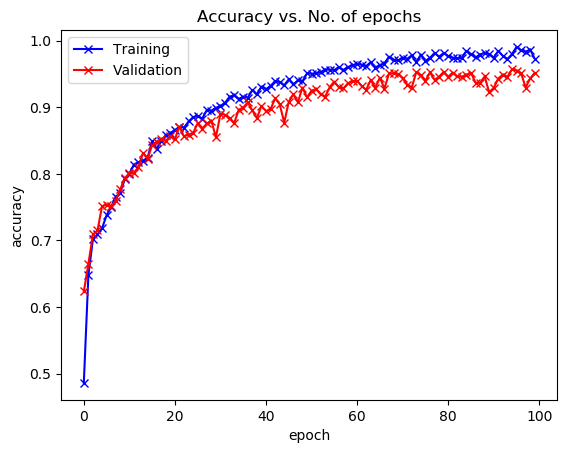

In [45]:
plot_accuracies(train_acc,val_acc_list)

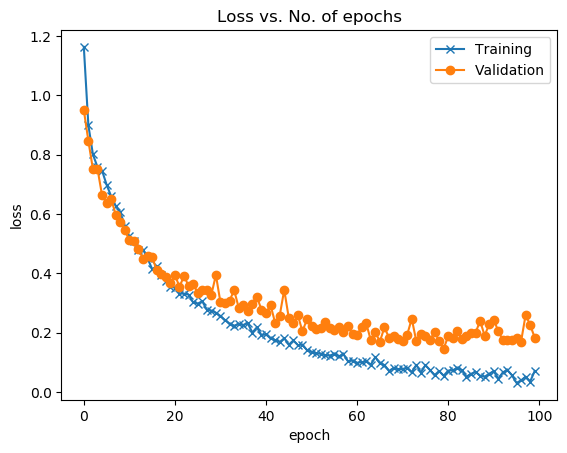

In [46]:
plot_losses(train_loss,val_loss_list)

In [26]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.3461 - acc: 0.3111 - val_loss : 1.3164 - val_acc: 0.4065



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.2728 - acc: 0.4415 - val_loss : 1.2373 - val_acc: 0.4934



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1858 - acc: 0.4934 - val_loss : 1.1600 - val_acc: 0.5092



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.1226 - acc: 0.5322 - val_loss : 1.1020 - val_acc: 0.5600



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.0817 - acc: 0.5585 - val_loss : 1.0639 - val_acc: 0.5668



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.0360 - acc: 0.5910 - val_loss : 1.0156 - val_acc: 0.6081



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.9881 - acc: 0.6153 - val_loss : 0.9605 - val_acc: 0.6241



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.9512 - acc: 0.6264 - val_loss : 0.9261 - val_acc: 0.6459



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.9195 - acc: 0.6422 - val_loss : 0.9065 - val_acc: 0.6479



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.9092 - acc: 0.6502 - val_loss : 0.8941 - val_acc: 0.6556



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.8975 - acc: 0.6494 - val_loss : 0.8870 - val_acc: 0.6658



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.8904 - acc: 0.6549 - val_loss : 0.8919 - val_acc: 0.6653



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.8913 - acc: 0.6569 - val_loss : 0.8996 - val_acc: 0.6476



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.8770 - acc: 0.6646 - val_loss : 0.8718 - val_acc: 0.6595



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.8707 - acc: 0.6654 - val_loss : 0.8723 - val_acc: 0.6630



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.8695 - acc: 0.6683 - val_loss : 0.8717 - val_acc: 0.6602



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.8618 - acc: 0.6718 - val_loss : 0.8539 - val_acc: 0.6783



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.8548 - acc: 0.6736 - val_loss : 0.8474 - val_acc: 0.6903



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.8476 - acc: 0.6813 - val_loss : 0.8585 - val_acc: 0.6658



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.8484 - acc: 0.6775 - val_loss : 0.8403 - val_acc: 0.6942



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.8451 - acc: 0.6732 - val_loss : 0.8363 - val_acc: 0.6790



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.8371 - acc: 0.6851 - val_loss : 0.8343 - val_acc: 0.7027



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.8324 - acc: 0.6839 - val_loss : 0.8227 - val_acc: 0.6815



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.8349 - acc: 0.6837 - val_loss : 0.8227 - val_acc: 0.6874



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.8253 - acc: 0.6887 - val_loss : 0.8416 - val_acc: 0.6703



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.8144 - acc: 0.6907 - val_loss : 0.8260 - val_acc: 0.6800



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.8161 - acc: 0.6912 - val_loss : 0.8152 - val_acc: 0.6917



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.8061 - acc: 0.6956 - val_loss : 0.8150 - val_acc: 0.6921



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.8015 - acc: 0.6962 - val_loss : 0.8194 - val_acc: 0.6734



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.8019 - acc: 0.6930 - val_loss : 0.7926 - val_acc: 0.7059



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.7916 - acc: 0.6983 - val_loss : 0.7876 - val_acc: 0.7121



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.7919 - acc: 0.6987 - val_loss : 0.8081 - val_acc: 0.6955



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.7802 - acc: 0.7070 - val_loss : 0.7773 - val_acc: 0.7138



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.7818 - acc: 0.7057 - val_loss : 0.7874 - val_acc: 0.7070



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.7711 - acc: 0.7109 - val_loss : 0.7721 - val_acc: 0.7062



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.7719 - acc: 0.7066 - val_loss : 0.7623 - val_acc: 0.7104



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.7657 - acc: 0.7068 - val_loss : 0.7685 - val_acc: 0.7150



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.7536 - acc: 0.7178 - val_loss : 0.7605 - val_acc: 0.7142



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.7637 - acc: 0.7127 - val_loss : 0.7774 - val_acc: 0.7027



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.7481 - acc: 0.7157 - val_loss : 0.7577 - val_acc: 0.7327



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.7560 - acc: 0.7115 - val_loss : 0.7495 - val_acc: 0.7156



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.7403 - acc: 0.7186 - val_loss : 0.7389 - val_acc: 0.7301



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.7367 - acc: 0.7189 - val_loss : 0.7477 - val_acc: 0.7277



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.7382 - acc: 0.7240 - val_loss : 0.7295 - val_acc: 0.7294



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.7326 - acc: 0.7242 - val_loss : 0.7415 - val_acc: 0.7350



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.7260 - acc: 0.7250 - val_loss : 0.7199 - val_acc: 0.7266



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.7181 - acc: 0.7246 - val_loss : 0.7202 - val_acc: 0.7309



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.7162 - acc: 0.7259 - val_loss : 0.7187 - val_acc: 0.7190



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.7155 - acc: 0.7262 - val_loss : 0.7255 - val_acc: 0.7249



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.7069 - acc: 0.7348 - val_loss : 0.6937 - val_acc: 0.7361



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.7002 - acc: 0.7338 - val_loss : 0.7081 - val_acc: 0.7275



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.6944 - acc: 0.7359 - val_loss : 0.6947 - val_acc: 0.7282



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.6884 - acc: 0.7369 - val_loss : 0.6794 - val_acc: 0.7522



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.6835 - acc: 0.7366 - val_loss : 0.6931 - val_acc: 0.7390



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.6824 - acc: 0.7394 - val_loss : 0.6844 - val_acc: 0.7384



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.6805 - acc: 0.7426 - val_loss : 0.7010 - val_acc: 0.7249



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.6792 - acc: 0.7375 - val_loss : 0.6741 - val_acc: 0.7453



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.6701 - acc: 0.7528 - val_loss : 0.6851 - val_acc: 0.7379



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.6618 - acc: 0.7493 - val_loss : 0.6901 - val_acc: 0.7253



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.6657 - acc: 0.7454 - val_loss : 0.6566 - val_acc: 0.7568



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.6494 - acc: 0.7567 - val_loss : 0.6585 - val_acc: 0.7422



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.6520 - acc: 0.7500 - val_loss : 0.6522 - val_acc: 0.7472



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.6400 - acc: 0.7620 - val_loss : 0.6409 - val_acc: 0.7672



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.6383 - acc: 0.7534 - val_loss : 0.6517 - val_acc: 0.7541



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.6373 - acc: 0.7548 - val_loss : 0.6374 - val_acc: 0.7603



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.6315 - acc: 0.7643 - val_loss : 0.6619 - val_acc: 0.7487



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.6410 - acc: 0.7612 - val_loss : 0.6359 - val_acc: 0.7666



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.6314 - acc: 0.7631 - val_loss : 0.6685 - val_acc: 0.7299



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.6352 - acc: 0.7609 - val_loss : 0.6380 - val_acc: 0.7676



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.6254 - acc: 0.7658 - val_loss : 0.6329 - val_acc: 0.7503



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.6294 - acc: 0.7603 - val_loss : 0.6152 - val_acc: 0.7733



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.6174 - acc: 0.7678 - val_loss : 0.6307 - val_acc: 0.7621



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.6107 - acc: 0.7704 - val_loss : 0.6297 - val_acc: 0.7699



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.6089 - acc: 0.7723 - val_loss : 0.6261 - val_acc: 0.7613



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.6051 - acc: 0.7735 - val_loss : 0.6129 - val_acc: 0.7707



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.6117 - acc: 0.7693 - val_loss : 0.6338 - val_acc: 0.7599



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.6033 - acc: 0.7752 - val_loss : 0.6399 - val_acc: 0.7401



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.6007 - acc: 0.7743 - val_loss : 0.6307 - val_acc: 0.7514



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.6033 - acc: 0.7761 - val_loss : 0.5942 - val_acc: 0.7773



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.5876 - acc: 0.7794 - val_loss : 0.6279 - val_acc: 0.7538



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.5891 - acc: 0.7819 - val_loss : 0.6082 - val_acc: 0.7624



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.5946 - acc: 0.7730 - val_loss : 0.6239 - val_acc: 0.7690



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.5853 - acc: 0.7818 - val_loss : 0.6217 - val_acc: 0.7581



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.5898 - acc: 0.7768 - val_loss : 0.5871 - val_acc: 0.7779



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.5824 - acc: 0.7804 - val_loss : 0.5963 - val_acc: 0.7804



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.5760 - acc: 0.7812 - val_loss : 0.6208 - val_acc: 0.7586



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.5841 - acc: 0.7864 - val_loss : 0.5879 - val_acc: 0.7648



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.5714 - acc: 0.7881 - val_loss : 0.5892 - val_acc: 0.7694



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.5786 - acc: 0.7807 - val_loss : 0.5865 - val_acc: 0.7795



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.5788 - acc: 0.7836 - val_loss : 0.6072 - val_acc: 0.7676



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.5765 - acc: 0.7814 - val_loss : 0.5815 - val_acc: 0.7863



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.5676 - acc: 0.7833 - val_loss : 0.5867 - val_acc: 0.7731



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.5701 - acc: 0.7858 - val_loss : 0.6110 - val_acc: 0.7627



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.5638 - acc: 0.7906 - val_loss : 0.6029 - val_acc: 0.7602



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5644 - acc: 0.7879 - val_loss : 0.5711 - val_acc: 0.7830



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.5692 - acc: 0.7850 - val_loss : 0.6050 - val_acc: 0.7648



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5653 - acc: 0.7900 - val_loss : 0.5969 - val_acc: 0.7728



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5610 - acc: 0.7930 - val_loss : 0.5698 - val_acc: 0.7817



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.5471 - acc: 0.7950 - val_loss : 0.5623 - val_acc: 0.7864



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5585 - acc: 0.7925 - val_loss : 0.5605 - val_acc: 0.7823



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.5522 - acc: 0.8014 - val_loss : 0.5727 - val_acc: 0.7792



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.5642 - acc: 0.7900 - val_loss : 0.5684 - val_acc: 0.7762



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.5514 - acc: 0.7926 - val_loss : 0.5650 - val_acc: 0.7825



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.5476 - acc: 0.7940 - val_loss : 0.5828 - val_acc: 0.7690



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.5465 - acc: 0.7948 - val_loss : 0.5622 - val_acc: 0.7890



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.5377 - acc: 0.7971 - val_loss : 0.5731 - val_acc: 0.7826



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.5450 - acc: 0.7964 - val_loss : 0.5575 - val_acc: 0.7903



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.5437 - acc: 0.8004 - val_loss : 0.5533 - val_acc: 0.7893



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.5386 - acc: 0.7990 - val_loss : 0.5706 - val_acc: 0.7748



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.5368 - acc: 0.8007 - val_loss : 0.5607 - val_acc: 0.7890



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.5405 - acc: 0.8000 - val_loss : 0.5605 - val_acc: 0.7811



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.5341 - acc: 0.8003 - val_loss : 0.5726 - val_acc: 0.7745



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.5302 - acc: 0.8073 - val_loss : 0.5445 - val_acc: 0.7869



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.5454 - acc: 0.7963 - val_loss : 0.5676 - val_acc: 0.7856



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.5407 - acc: 0.7994 - val_loss : 0.5465 - val_acc: 0.7946



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.5259 - acc: 0.8078 - val_loss : 0.5765 - val_acc: 0.7677



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.5231 - acc: 0.8091 - val_loss : 0.5697 - val_acc: 0.7745



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.5258 - acc: 0.8093 - val_loss : 0.5490 - val_acc: 0.7987



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.5240 - acc: 0.8051 - val_loss : 0.5479 - val_acc: 0.8004



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.5277 - acc: 0.8012 - val_loss : 0.5231 - val_acc: 0.7994



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 121 - loss : 0.5203 - acc: 0.8053 - val_loss : 0.5361 - val_acc: 0.7966



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 122 - loss : 0.5188 - acc: 0.8092 - val_loss : 0.5587 - val_acc: 0.7856



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 123 - loss : 0.5196 - acc: 0.8090 - val_loss : 0.5400 - val_acc: 0.7857



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 124 - loss : 0.5173 - acc: 0.8111 - val_loss : 0.5487 - val_acc: 0.7882



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 125 - loss : 0.5157 - acc: 0.8072 - val_loss : 0.5335 - val_acc: 0.7911



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 126 - loss : 0.5153 - acc: 0.8078 - val_loss : 0.5311 - val_acc: 0.7936



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 127 - loss : 0.5148 - acc: 0.8072 - val_loss : 0.5447 - val_acc: 0.7870



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 128 - loss : 0.5110 - acc: 0.8102 - val_loss : 0.5449 - val_acc: 0.7850



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 129 - loss : 0.5131 - acc: 0.8125 - val_loss : 0.5693 - val_acc: 0.7664



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 130 - loss : 0.5134 - acc: 0.8154 - val_loss : 0.5581 - val_acc: 0.7757



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 131 - loss : 0.5167 - acc: 0.8074 - val_loss : 0.5207 - val_acc: 0.8033



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 132 - loss : 0.5127 - acc: 0.8069 - val_loss : 0.5255 - val_acc: 0.7978



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 133 - loss : 0.5108 - acc: 0.8055 - val_loss : 0.5197 - val_acc: 0.8060



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 134 - loss : 0.4989 - acc: 0.8143 - val_loss : 0.5377 - val_acc: 0.7897



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 135 - loss : 0.5052 - acc: 0.8155 - val_loss : 0.5236 - val_acc: 0.7961



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 136 - loss : 0.5063 - acc: 0.8182 - val_loss : 0.5769 - val_acc: 0.7795



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 137 - loss : 0.5072 - acc: 0.8098 - val_loss : 0.5126 - val_acc: 0.8131



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 138 - loss : 0.5017 - acc: 0.8103 - val_loss : 0.5326 - val_acc: 0.7862



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 139 - loss : 0.5072 - acc: 0.8112 - val_loss : 0.5278 - val_acc: 0.7980



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 140 - loss : 0.5016 - acc: 0.8152 - val_loss : 0.5676 - val_acc: 0.7821



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 141 - loss : 0.5103 - acc: 0.8089 - val_loss : 0.5176 - val_acc: 0.8038



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 142 - loss : 0.4994 - acc: 0.8131 - val_loss : 0.5395 - val_acc: 0.7847



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 143 - loss : 0.4976 - acc: 0.8109 - val_loss : 0.5106 - val_acc: 0.8069



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 144 - loss : 0.4938 - acc: 0.8152 - val_loss : 0.5533 - val_acc: 0.7852



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 145 - loss : 0.4943 - acc: 0.8188 - val_loss : 0.5092 - val_acc: 0.8016



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 146 - loss : 0.4941 - acc: 0.8151 - val_loss : 0.5214 - val_acc: 0.8046



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 147 - loss : 0.4973 - acc: 0.8125 - val_loss : 0.5093 - val_acc: 0.8063



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 148 - loss : 0.4891 - acc: 0.8225 - val_loss : 0.5033 - val_acc: 0.8097



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 149 - loss : 0.4823 - acc: 0.8171 - val_loss : 0.5093 - val_acc: 0.8153



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 150 - loss : 0.4845 - acc: 0.8193 - val_loss : 0.5097 - val_acc: 0.8106



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 151 - loss : 0.4882 - acc: 0.8162 - val_loss : 0.5041 - val_acc: 0.8080



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 152 - loss : 0.4826 - acc: 0.8183 - val_loss : 0.4939 - val_acc: 0.8075



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 153 - loss : 0.4804 - acc: 0.8184 - val_loss : 0.5024 - val_acc: 0.8108



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 154 - loss : 0.4814 - acc: 0.8205 - val_loss : 0.5311 - val_acc: 0.7806



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 155 - loss : 0.4948 - acc: 0.8166 - val_loss : 0.5066 - val_acc: 0.8060



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 156 - loss : 0.4768 - acc: 0.8260 - val_loss : 0.4966 - val_acc: 0.8140



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 157 - loss : 0.4805 - acc: 0.8223 - val_loss : 0.4997 - val_acc: 0.8106



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 158 - loss : 0.4763 - acc: 0.8207 - val_loss : 0.5028 - val_acc: 0.8099



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 159 - loss : 0.4814 - acc: 0.8250 - val_loss : 0.4922 - val_acc: 0.8084



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 160 - loss : 0.4778 - acc: 0.8202 - val_loss : 0.5118 - val_acc: 0.7995



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 161 - loss : 0.4803 - acc: 0.8188 - val_loss : 0.5299 - val_acc: 0.7873



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 162 - loss : 0.4810 - acc: 0.8231 - val_loss : 0.5083 - val_acc: 0.8067



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 163 - loss : 0.4772 - acc: 0.8268 - val_loss : 0.4999 - val_acc: 0.8140



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 164 - loss : 0.4732 - acc: 0.8221 - val_loss : 0.5320 - val_acc: 0.7903



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 165 - loss : 0.4744 - acc: 0.8238 - val_loss : 0.4887 - val_acc: 0.8153



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 166 - loss : 0.4753 - acc: 0.8213 - val_loss : 0.4846 - val_acc: 0.8174



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 167 - loss : 0.4690 - acc: 0.8247 - val_loss : 0.4946 - val_acc: 0.8141



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 168 - loss : 0.4687 - acc: 0.8253 - val_loss : 0.4909 - val_acc: 0.8162



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 169 - loss : 0.4737 - acc: 0.8277 - val_loss : 0.4901 - val_acc: 0.8070



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 170 - loss : 0.4765 - acc: 0.8228 - val_loss : 0.5039 - val_acc: 0.8076



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 171 - loss : 0.4808 - acc: 0.8210 - val_loss : 0.5218 - val_acc: 0.7970



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 172 - loss : 0.4735 - acc: 0.8195 - val_loss : 0.4850 - val_acc: 0.8144



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 173 - loss : 0.4632 - acc: 0.8288 - val_loss : 0.4809 - val_acc: 0.8168



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 174 - loss : 0.4743 - acc: 0.8239 - val_loss : 0.5069 - val_acc: 0.8105



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 175 - loss : 0.4655 - acc: 0.8239 - val_loss : 0.4851 - val_acc: 0.8120



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 176 - loss : 0.4699 - acc: 0.8246 - val_loss : 0.4729 - val_acc: 0.8249



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 177 - loss : 0.4595 - acc: 0.8295 - val_loss : 0.4895 - val_acc: 0.8068



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 178 - loss : 0.4633 - acc: 0.8269 - val_loss : 0.4857 - val_acc: 0.8111



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 179 - loss : 0.4666 - acc: 0.8292 - val_loss : 0.4763 - val_acc: 0.8263



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 180 - loss : 0.4593 - acc: 0.8276 - val_loss : 0.4844 - val_acc: 0.8145



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 181 - loss : 0.4561 - acc: 0.8274 - val_loss : 0.4864 - val_acc: 0.8152



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 182 - loss : 0.4576 - acc: 0.8308 - val_loss : 0.4903 - val_acc: 0.8140



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 183 - loss : 0.4578 - acc: 0.8242 - val_loss : 0.4753 - val_acc: 0.8199



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 184 - loss : 0.4602 - acc: 0.8304 - val_loss : 0.4837 - val_acc: 0.8137



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 185 - loss : 0.4659 - acc: 0.8302 - val_loss : 0.4890 - val_acc: 0.8111



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 186 - loss : 0.4489 - acc: 0.8321 - val_loss : 0.4828 - val_acc: 0.8141



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 187 - loss : 0.4591 - acc: 0.8261 - val_loss : 0.4842 - val_acc: 0.8161



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 188 - loss : 0.4507 - acc: 0.8321 - val_loss : 0.4756 - val_acc: 0.8170



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 189 - loss : 0.4493 - acc: 0.8305 - val_loss : 0.4917 - val_acc: 0.8184



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 190 - loss : 0.4506 - acc: 0.8316 - val_loss : 0.5078 - val_acc: 0.8033



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 191 - loss : 0.4545 - acc: 0.8306 - val_loss : 0.4991 - val_acc: 0.8048



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 192 - loss : 0.4522 - acc: 0.8337 - val_loss : 0.4975 - val_acc: 0.8101



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 193 - loss : 0.4547 - acc: 0.8285 - val_loss : 0.5008 - val_acc: 0.8134



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 194 - loss : 0.4592 - acc: 0.8330 - val_loss : 0.4760 - val_acc: 0.8234



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 195 - loss : 0.4494 - acc: 0.8363 - val_loss : 0.5093 - val_acc: 0.8029



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 196 - loss : 0.4455 - acc: 0.8349 - val_loss : 0.4805 - val_acc: 0.8159



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 197 - loss : 0.4440 - acc: 0.8334 - val_loss : 0.4696 - val_acc: 0.8243



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 198 - loss : 0.4451 - acc: 0.8326 - val_loss : 0.4627 - val_acc: 0.8296



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 199 - loss : 0.4436 - acc: 0.8293 - val_loss : 0.4828 - val_acc: 0.8152



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 200 - loss : 0.4393 - acc: 0.8388 - val_loss : 0.4633 - val_acc: 0.8281



### Deep ViT (lr=1e-5)

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.2280 - acc: 0.4310 - val_loss : 1.1267 - val_acc: 0.5111



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1143 - acc: 0.5166 - val_loss : 1.1070 - val_acc: 0.5173



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.9946 - acc: 0.5969 - val_loss : 0.8781 - val_acc: 0.6660



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.9119 - acc: 0.6406 - val_loss : 0.8920 - val_acc: 0.6472



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8859 - acc: 0.6556 - val_loss : 0.8281 - val_acc: 0.7036



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.8255 - acc: 0.6872 - val_loss : 0.8563 - val_acc: 0.6643



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.8041 - acc: 0.6947 - val_loss : 0.8037 - val_acc: 0.6967



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.7670 - acc: 0.7067 - val_loss : 0.7073 - val_acc: 0.7294



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.7287 - acc: 0.7127 - val_loss : 0.7050 - val_acc: 0.7274



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6785 - acc: 0.7344 - val_loss : 0.6455 - val_acc: 0.7473



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6467 - acc: 0.7466 - val_loss : 0.6078 - val_acc: 0.7684



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6227 - acc: 0.7556 - val_loss : 0.5680 - val_acc: 0.7754



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5981 - acc: 0.7646 - val_loss : 0.5903 - val_acc: 0.7757



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5789 - acc: 0.7727 - val_loss : 0.7934 - val_acc: 0.6923



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5713 - acc: 0.7767 - val_loss : 0.5910 - val_acc: 0.7537



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5441 - acc: 0.7871 - val_loss : 0.5430 - val_acc: 0.7868



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5515 - acc: 0.7859 - val_loss : 0.5388 - val_acc: 0.7927



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5490 - acc: 0.7786 - val_loss : 0.5034 - val_acc: 0.8016



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5057 - acc: 0.8049 - val_loss : 0.5159 - val_acc: 0.7868



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5243 - acc: 0.7918 - val_loss : 0.4969 - val_acc: 0.8017



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5153 - acc: 0.7943 - val_loss : 0.4798 - val_acc: 0.8020



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.4733 - acc: 0.8122 - val_loss : 0.4939 - val_acc: 0.7966



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.4716 - acc: 0.8096 - val_loss : 0.4716 - val_acc: 0.8131



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.4507 - acc: 0.8216 - val_loss : 0.4548 - val_acc: 0.8256



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.4354 - acc: 0.8295 - val_loss : 0.4854 - val_acc: 0.8065



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.4388 - acc: 0.8297 - val_loss : 0.4369 - val_acc: 0.8175



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.4386 - acc: 0.8263 - val_loss : 0.4335 - val_acc: 0.8310



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.4286 - acc: 0.8308 - val_loss : 0.4624 - val_acc: 0.8234



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.4436 - acc: 0.8184 - val_loss : 0.4361 - val_acc: 0.8244



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.4290 - acc: 0.8281 - val_loss : 0.4177 - val_acc: 0.8394



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.4017 - acc: 0.8374 - val_loss : 0.4113 - val_acc: 0.8258



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.3996 - acc: 0.8424 - val_loss : 0.4782 - val_acc: 0.8060



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.3896 - acc: 0.8436 - val_loss : 0.3860 - val_acc: 0.8505



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.3905 - acc: 0.8450 - val_loss : 0.4189 - val_acc: 0.8187



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.3936 - acc: 0.8458 - val_loss : 0.4415 - val_acc: 0.8293



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.3685 - acc: 0.8547 - val_loss : 0.4102 - val_acc: 0.8381



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.3619 - acc: 0.8556 - val_loss : 0.4173 - val_acc: 0.8283



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.3574 - acc: 0.8583 - val_loss : 0.4351 - val_acc: 0.8356



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.3531 - acc: 0.8596 - val_loss : 0.4047 - val_acc: 0.8402



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.3320 - acc: 0.8686 - val_loss : 0.3972 - val_acc: 0.8467



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.3443 - acc: 0.8663 - val_loss : 0.3808 - val_acc: 0.8456



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.3407 - acc: 0.8613 - val_loss : 0.3690 - val_acc: 0.8634



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.3290 - acc: 0.8714 - val_loss : 0.3702 - val_acc: 0.8638



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.3193 - acc: 0.8734 - val_loss : 0.4134 - val_acc: 0.8480



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.3218 - acc: 0.8734 - val_loss : 0.4023 - val_acc: 0.8480



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.3230 - acc: 0.8646 - val_loss : 0.3526 - val_acc: 0.8679



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.2992 - acc: 0.8822 - val_loss : 0.3897 - val_acc: 0.8447



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.3052 - acc: 0.8780 - val_loss : 0.4901 - val_acc: 0.8203



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.3106 - acc: 0.8706 - val_loss : 0.3788 - val_acc: 0.8629



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.3021 - acc: 0.8770 - val_loss : 0.3722 - val_acc: 0.8570



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.2954 - acc: 0.8790 - val_loss : 0.3713 - val_acc: 0.8641



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.2846 - acc: 0.8880 - val_loss : 0.3867 - val_acc: 0.8503



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.2871 - acc: 0.8868 - val_loss : 0.3480 - val_acc: 0.8620



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.2884 - acc: 0.8866 - val_loss : 0.3586 - val_acc: 0.8794



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.2949 - acc: 0.8825 - val_loss : 0.3456 - val_acc: 0.8698



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.2641 - acc: 0.8987 - val_loss : 0.3532 - val_acc: 0.8658



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.2760 - acc: 0.8853 - val_loss : 0.4149 - val_acc: 0.8479



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.2783 - acc: 0.8909 - val_loss : 0.3308 - val_acc: 0.8785



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.2613 - acc: 0.8949 - val_loss : 0.3364 - val_acc: 0.8846



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.2708 - acc: 0.8946 - val_loss : 0.3437 - val_acc: 0.8611



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.2662 - acc: 0.8979 - val_loss : 0.3309 - val_acc: 0.8815



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.2628 - acc: 0.8960 - val_loss : 0.3542 - val_acc: 0.8738



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.2604 - acc: 0.8962 - val_loss : 0.3277 - val_acc: 0.8780



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.2499 - acc: 0.9029 - val_loss : 0.3366 - val_acc: 0.8803



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.2403 - acc: 0.9091 - val_loss : 0.3541 - val_acc: 0.8811



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.2562 - acc: 0.9050 - val_loss : 0.3905 - val_acc: 0.8435



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.2506 - acc: 0.9017 - val_loss : 0.3395 - val_acc: 0.8823



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.2311 - acc: 0.9096 - val_loss : 0.3164 - val_acc: 0.8840



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.2448 - acc: 0.9066 - val_loss : 0.3289 - val_acc: 0.8798



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.2397 - acc: 0.9071 - val_loss : 0.3257 - val_acc: 0.8854



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.2226 - acc: 0.9146 - val_loss : 0.3138 - val_acc: 0.8854



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.2148 - acc: 0.9182 - val_loss : 0.3132 - val_acc: 0.8943



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.2307 - acc: 0.9145 - val_loss : 0.3364 - val_acc: 0.8819



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.2192 - acc: 0.9161 - val_loss : 0.3300 - val_acc: 0.8807



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.2498 - acc: 0.9044 - val_loss : 0.3054 - val_acc: 0.8939



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.2219 - acc: 0.9076 - val_loss : 0.3189 - val_acc: 0.8892



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.2274 - acc: 0.9130 - val_loss : 0.3075 - val_acc: 0.8836



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.2128 - acc: 0.9172 - val_loss : 0.3171 - val_acc: 0.8982



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.2156 - acc: 0.9212 - val_loss : 0.3114 - val_acc: 0.8862



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.2121 - acc: 0.9162 - val_loss : 0.3128 - val_acc: 0.8793



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.2051 - acc: 0.9215 - val_loss : 0.3470 - val_acc: 0.8774



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.2186 - acc: 0.9187 - val_loss : 0.2994 - val_acc: 0.8959



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.2121 - acc: 0.9185 - val_loss : 0.3061 - val_acc: 0.8879



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.1988 - acc: 0.9254 - val_loss : 0.3036 - val_acc: 0.9003



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.1951 - acc: 0.9249 - val_loss : 0.3111 - val_acc: 0.8904



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.2038 - acc: 0.9238 - val_loss : 0.3233 - val_acc: 0.8875



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.1984 - acc: 0.9254 - val_loss : 0.3153 - val_acc: 0.8875



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.1939 - acc: 0.9246 - val_loss : 0.3017 - val_acc: 0.8917



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.1991 - acc: 0.9254 - val_loss : 0.3554 - val_acc: 0.8689



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.2092 - acc: 0.9220 - val_loss : 0.3115 - val_acc: 0.8926



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.1824 - acc: 0.9290 - val_loss : 0.3031 - val_acc: 0.8980



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.1741 - acc: 0.9357 - val_loss : 0.2795 - val_acc: 0.9027



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.1855 - acc: 0.9297 - val_loss : 0.3455 - val_acc: 0.8895



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.1943 - acc: 0.9207 - val_loss : 0.3279 - val_acc: 0.8883



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.1864 - acc: 0.9296 - val_loss : 0.3018 - val_acc: 0.8888



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.1825 - acc: 0.9301 - val_loss : 0.2857 - val_acc: 0.9018



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.1708 - acc: 0.9341 - val_loss : 0.3275 - val_acc: 0.8967



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.1838 - acc: 0.9309 - val_loss : 0.2886 - val_acc: 0.8956



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.1730 - acc: 0.9316 - val_loss : 0.3166 - val_acc: 0.8972



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.1716 - acc: 0.9363 - val_loss : 0.3114 - val_acc: 0.8879

Epoch:99
Loss value in the last epoch of training is:0.17158176004886627
Accuracy in the last epoch of training is:0.936325192451477
Accuracy of training:0.8517005909389364
Precision of training:0.8517005909389364
Recall of training:0.8517005909389364
Micro f1 score of training:0.8517005909389364
Classification report of training:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81    105700
           1       0.75      0.74      0.75    107100
           2       0.92      0.92      0.92    127600
           3       0.89      0.93      0.91    116500

    accuracy                           0.85    456900
   macro avg       0.85      0.85      0.85    456900
weighted avg       0.85      0.85      0.85    456900

Confusion matrix of training:
[[ 83706  17891    941   3162]
 [ 13787  79076   7464   6773]
 [  2124   4055 117995   3426]
 [  2282   3863   1990 10836

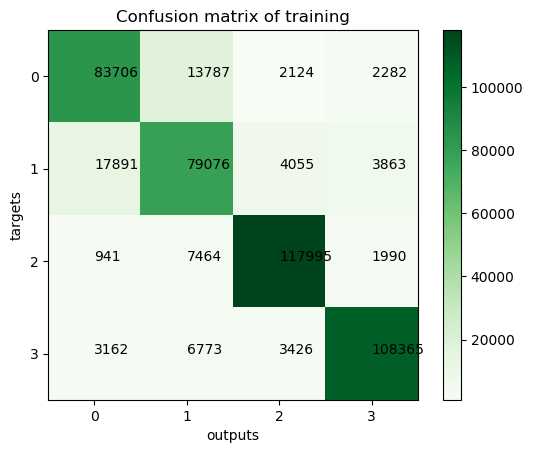

Loss value in the last epoch of validation is:0.31143227219581604
Accuracy in the last epoch of validation is:0.8878660798072815
Accuracy of validation:0.8351268591426072
Precision of validation:0.8351268591426072
Recall of validation:0.8351268591426072
Micro f1 score of validation:0.8351268591426072
Classification report of validation:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     26400
           1       0.72      0.70      0.71     26800
           2       0.89      0.90      0.90     31900
           3       0.89      0.95      0.92     29200

    accuracy                           0.84    114300
   macro avg       0.83      0.83      0.83    114300
weighted avg       0.83      0.84      0.83    114300

Confusion matrix of validation:
[[20206  5146   222   826]
 [ 3581 18854  2811  1554]
 [  618  1571 28772   939]
 [  368   791   418 27623]]


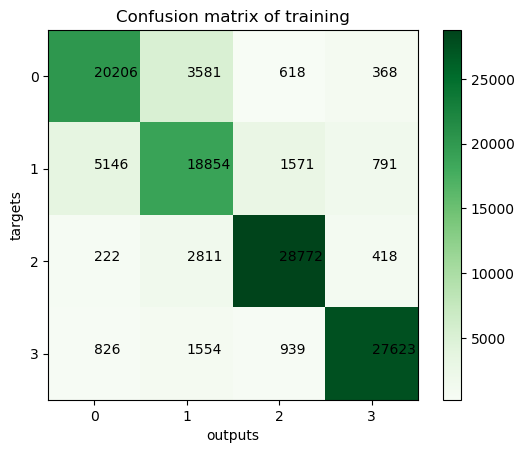

In [49]:
train_loss = []
train_acc = []
val_loss_list = []
val_acc_list = []
outputs_train = []
outputs_val = []
targets_train = []
targets_val = []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        outputs_train.extend(item.cpu().detach().numpy() for item in output.argmax(1))
        targets_train.extend(item.cpu().detach().numpy() for item in label)
        
    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            
            outputs_val.extend(item.cpu().detach().numpy() for item in val_output.argmax(1))
            targets_val.extend(item.cpu().detach().numpy() for item in label)
            
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

######################################################################################################################################    
print("Epoch:{}".format(epoch))
print("Loss value in the last epoch of training is:{}".format(epoch_loss))
print("Accuracy in the last epoch of training is:{}".format(epoch_accuracy))

sklearn_accuracy1 = accuracy_score(targets_train, outputs_train)
sklearn_precision1 = precision_score(targets_train, outputs_train, average='micro')
sklearn_recall1 = recall_score(targets_train, outputs_train, average='micro')
sklearn_f11 = f1_score(targets_train, outputs_train, average='micro')
print("Accuracy of training:{}".format(sklearn_accuracy1))
print("Precision of training:{}".format(sklearn_precision1))
print("Recall of training:{}".format(sklearn_recall1))
print("Micro f1 score of training:{}".format(sklearn_f11))

sklearn_report1 = classification_report(targets_train, outputs_train)
print("Classification report of training:")
print(sklearn_report1)

conf_matrix1 = get_confusion_matrix(targets_train, outputs_train)
print("Confusion matrix of training:")
print(conf_matrix1)
plot_confusion_matrix(conf_matrix1,epoch)

#####################################################################################################################################
print("Loss value in the last epoch of validation is:{}".format(epoch_val_loss))
print("Accuracy in the last epoch of validation is:{}".format(epoch_val_accuracy))

sklearn_accuracy2 = accuracy_score(targets_val, outputs_val)
sklearn_precision2 = precision_score(targets_val, outputs_val, average='micro')
sklearn_recall2 = recall_score(targets_val, outputs_val, average='micro')
sklearn_f12 = f1_score(targets_val, outputs_val, average='micro')
print("Accuracy of validation:{}".format(sklearn_accuracy2))
print("Precision of validation:{}".format(sklearn_precision2))
print("Recall of validation:{}".format(sklearn_recall2))
print("Micro f1 score of validation:{}".format(sklearn_f12))

sklearn_report2 = classification_report(targets_val, outputs_val)
print("Classification report of validation:")
print(sklearn_report2)

conf_matrix2 = get_confusion_matrix(targets_val, outputs_val)
print("Confusion matrix of validation:")
print(conf_matrix2)
plot_confusion_matrix(conf_matrix2,epoch)


In [26]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.2631 - acc: 0.4039 - val_loss : 1.1816 - val_acc: 0.4778



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1642 - acc: 0.4779 - val_loss : 1.1387 - val_acc: 0.4955



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1288 - acc: 0.5084 - val_loss : 1.1291 - val_acc: 0.4977



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.1219 - acc: 0.5105 - val_loss : 1.1100 - val_acc: 0.5209



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.0911 - acc: 0.5309 - val_loss : 1.1086 - val_acc: 0.4926



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.0695 - acc: 0.5484 - val_loss : 1.0615 - val_acc: 0.5464



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.0337 - acc: 0.5679 - val_loss : 1.0192 - val_acc: 0.6008



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.9935 - acc: 0.5918 - val_loss : 0.9856 - val_acc: 0.6008



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.9301 - acc: 0.6262 - val_loss : 0.9425 - val_acc: 0.6480



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.8936 - acc: 0.6555 - val_loss : 0.9090 - val_acc: 0.6619



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.8989 - acc: 0.6497 - val_loss : 0.8863 - val_acc: 0.6554



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.8711 - acc: 0.6645 - val_loss : 0.8724 - val_acc: 0.6714



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.8751 - acc: 0.6654 - val_loss : 0.8551 - val_acc: 0.6684



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.8573 - acc: 0.6689 - val_loss : 0.8330 - val_acc: 0.6807



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.8303 - acc: 0.6813 - val_loss : 0.8600 - val_acc: 0.6757



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.8323 - acc: 0.6773 - val_loss : 0.8172 - val_acc: 0.6757



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.8130 - acc: 0.6837 - val_loss : 0.8049 - val_acc: 0.6918



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.7958 - acc: 0.6944 - val_loss : 0.8266 - val_acc: 0.6732



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.7848 - acc: 0.6978 - val_loss : 0.8233 - val_acc: 0.6643



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.7847 - acc: 0.6913 - val_loss : 0.7548 - val_acc: 0.7246



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.7753 - acc: 0.6977 - val_loss : 0.8337 - val_acc: 0.6836



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.7529 - acc: 0.7070 - val_loss : 0.7307 - val_acc: 0.7203



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.7544 - acc: 0.7085 - val_loss : 0.7322 - val_acc: 0.7198



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.7572 - acc: 0.7105 - val_loss : 0.7193 - val_acc: 0.7345



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.7390 - acc: 0.7115 - val_loss : 0.7343 - val_acc: 0.7188



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.7284 - acc: 0.7182 - val_loss : 0.7769 - val_acc: 0.6991



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.7252 - acc: 0.7179 - val_loss : 0.6897 - val_acc: 0.7338



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.7223 - acc: 0.7232 - val_loss : 0.6964 - val_acc: 0.7429



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.7088 - acc: 0.7281 - val_loss : 0.7057 - val_acc: 0.7362



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.7045 - acc: 0.7322 - val_loss : 0.6933 - val_acc: 0.7282



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6932 - acc: 0.7345 - val_loss : 0.6705 - val_acc: 0.7501



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6901 - acc: 0.7311 - val_loss : 0.6959 - val_acc: 0.7213



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.6797 - acc: 0.7387 - val_loss : 0.6772 - val_acc: 0.7374



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6779 - acc: 0.7362 - val_loss : 0.6348 - val_acc: 0.7588



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.6691 - acc: 0.7450 - val_loss : 0.6727 - val_acc: 0.7410



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.6672 - acc: 0.7444 - val_loss : 0.6691 - val_acc: 0.7352



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.6572 - acc: 0.7518 - val_loss : 0.6451 - val_acc: 0.7436



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6454 - acc: 0.7557 - val_loss : 0.6295 - val_acc: 0.7696



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6477 - acc: 0.7523 - val_loss : 0.6411 - val_acc: 0.7557



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6464 - acc: 0.7542 - val_loss : 0.6416 - val_acc: 0.7518



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6250 - acc: 0.7651 - val_loss : 0.6280 - val_acc: 0.7711



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.6329 - acc: 0.7582 - val_loss : 0.6385 - val_acc: 0.7486



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6097 - acc: 0.7644 - val_loss : 0.6632 - val_acc: 0.7427



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.6234 - acc: 0.7595 - val_loss : 0.6128 - val_acc: 0.7520



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.6089 - acc: 0.7743 - val_loss : 0.5979 - val_acc: 0.7610



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5976 - acc: 0.7677 - val_loss : 0.6107 - val_acc: 0.7626



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.6063 - acc: 0.7677 - val_loss : 0.6040 - val_acc: 0.7638



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5910 - acc: 0.7730 - val_loss : 0.5860 - val_acc: 0.7748



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5835 - acc: 0.7742 - val_loss : 0.5822 - val_acc: 0.7783



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5812 - acc: 0.7765 - val_loss : 0.5732 - val_acc: 0.7796



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.5862 - acc: 0.7712 - val_loss : 0.5859 - val_acc: 0.7669



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5698 - acc: 0.7878 - val_loss : 0.6067 - val_acc: 0.7778



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.5860 - acc: 0.7698 - val_loss : 0.5911 - val_acc: 0.7738



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5712 - acc: 0.7859 - val_loss : 0.5840 - val_acc: 0.7761



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.5632 - acc: 0.7809 - val_loss : 0.5660 - val_acc: 0.7773



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.5617 - acc: 0.7877 - val_loss : 0.5912 - val_acc: 0.7650



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.5549 - acc: 0.7850 - val_loss : 0.5988 - val_acc: 0.7632



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.5499 - acc: 0.7877 - val_loss : 0.5681 - val_acc: 0.7796



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.5526 - acc: 0.7806 - val_loss : 0.5452 - val_acc: 0.7940



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5509 - acc: 0.7877 - val_loss : 0.5611 - val_acc: 0.7701



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5486 - acc: 0.7859 - val_loss : 0.5910 - val_acc: 0.7558



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5473 - acc: 0.7865 - val_loss : 0.5691 - val_acc: 0.7711



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5471 - acc: 0.7956 - val_loss : 0.5451 - val_acc: 0.7856



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.5371 - acc: 0.7954 - val_loss : 0.5760 - val_acc: 0.7806



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.5435 - acc: 0.7929 - val_loss : 0.5267 - val_acc: 0.7959



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.5472 - acc: 0.7865 - val_loss : 0.5402 - val_acc: 0.7893



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5429 - acc: 0.7902 - val_loss : 0.5516 - val_acc: 0.7873



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.5347 - acc: 0.7979 - val_loss : 0.5308 - val_acc: 0.7887



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5370 - acc: 0.7955 - val_loss : 0.5504 - val_acc: 0.7846



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5324 - acc: 0.7884 - val_loss : 0.5186 - val_acc: 0.7918



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.5204 - acc: 0.7945 - val_loss : 0.5197 - val_acc: 0.8097



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.5297 - acc: 0.7919 - val_loss : 0.5654 - val_acc: 0.7709



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.5224 - acc: 0.8016 - val_loss : 0.5337 - val_acc: 0.7881



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.5136 - acc: 0.7935 - val_loss : 0.5064 - val_acc: 0.8012



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.5079 - acc: 0.8043 - val_loss : 0.5315 - val_acc: 0.7915



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.5180 - acc: 0.8061 - val_loss : 0.5129 - val_acc: 0.8042



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5112 - acc: 0.8016 - val_loss : 0.5085 - val_acc: 0.8034



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.5021 - acc: 0.8075 - val_loss : 0.5153 - val_acc: 0.7931



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.5069 - acc: 0.8078 - val_loss : 0.4995 - val_acc: 0.7977



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.5008 - acc: 0.8088 - val_loss : 0.5071 - val_acc: 0.7943



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.4997 - acc: 0.8039 - val_loss : 0.5088 - val_acc: 0.8000



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.4965 - acc: 0.8131 - val_loss : 0.4891 - val_acc: 0.8094



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.4784 - acc: 0.8093 - val_loss : 0.5052 - val_acc: 0.7967



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.4945 - acc: 0.7998 - val_loss : 0.5196 - val_acc: 0.7953



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.4912 - acc: 0.8061 - val_loss : 0.5110 - val_acc: 0.8028



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.4825 - acc: 0.8120 - val_loss : 0.5135 - val_acc: 0.7923



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.4785 - acc: 0.8113 - val_loss : 0.4843 - val_acc: 0.8029



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.4738 - acc: 0.8193 - val_loss : 0.4782 - val_acc: 0.8106



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.4801 - acc: 0.8161 - val_loss : 0.4855 - val_acc: 0.8046



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.4779 - acc: 0.8145 - val_loss : 0.5098 - val_acc: 0.7879



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.4780 - acc: 0.8114 - val_loss : 0.5153 - val_acc: 0.7934



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.4833 - acc: 0.8148 - val_loss : 0.5009 - val_acc: 0.7993



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.4717 - acc: 0.8180 - val_loss : 0.4723 - val_acc: 0.8059



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.4617 - acc: 0.8201 - val_loss : 0.4846 - val_acc: 0.7987



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.4620 - acc: 0.8180 - val_loss : 0.4790 - val_acc: 0.8127



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.4759 - acc: 0.8155 - val_loss : 0.4793 - val_acc: 0.8147



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.4526 - acc: 0.8212 - val_loss : 0.5087 - val_acc: 0.8022



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.4637 - acc: 0.8183 - val_loss : 0.4688 - val_acc: 0.8173



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.4500 - acc: 0.8216 - val_loss : 0.4990 - val_acc: 0.8016



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.4523 - acc: 0.8236 - val_loss : 0.4655 - val_acc: 0.8044



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.4547 - acc: 0.8230 - val_loss : 0.4517 - val_acc: 0.8232



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.4515 - acc: 0.8215 - val_loss : 0.4990 - val_acc: 0.8096



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.4551 - acc: 0.8199 - val_loss : 0.4574 - val_acc: 0.8147



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.4352 - acc: 0.8293 - val_loss : 0.4677 - val_acc: 0.8085



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.4506 - acc: 0.8175 - val_loss : 0.5081 - val_acc: 0.7992



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.4418 - acc: 0.8264 - val_loss : 0.4495 - val_acc: 0.8249



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.4427 - acc: 0.8240 - val_loss : 0.4841 - val_acc: 0.8051



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.4389 - acc: 0.8283 - val_loss : 0.4875 - val_acc: 0.8212



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.4338 - acc: 0.8260 - val_loss : 0.5134 - val_acc: 0.8038



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.4423 - acc: 0.8226 - val_loss : 0.4592 - val_acc: 0.8135



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.4323 - acc: 0.8322 - val_loss : 0.4624 - val_acc: 0.8045



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.4297 - acc: 0.8302 - val_loss : 0.4434 - val_acc: 0.8242



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.4312 - acc: 0.8258 - val_loss : 0.4517 - val_acc: 0.8175



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.4210 - acc: 0.8380 - val_loss : 0.4491 - val_acc: 0.8220



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.4193 - acc: 0.8366 - val_loss : 0.4691 - val_acc: 0.8276



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.4226 - acc: 0.8294 - val_loss : 0.4393 - val_acc: 0.8192



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.4242 - acc: 0.8331 - val_loss : 0.4424 - val_acc: 0.8247



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.4109 - acc: 0.8411 - val_loss : 0.4758 - val_acc: 0.8117



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.4141 - acc: 0.8398 - val_loss : 0.4418 - val_acc: 0.8288



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.4160 - acc: 0.8335 - val_loss : 0.4630 - val_acc: 0.8228



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 121 - loss : 0.4119 - acc: 0.8406 - val_loss : 0.4589 - val_acc: 0.8102



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 122 - loss : 0.4085 - acc: 0.8424 - val_loss : 0.4399 - val_acc: 0.8280



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 123 - loss : 0.4051 - acc: 0.8395 - val_loss : 0.4289 - val_acc: 0.8253



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 124 - loss : 0.4128 - acc: 0.8421 - val_loss : 0.4325 - val_acc: 0.8328



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 125 - loss : 0.4094 - acc: 0.8369 - val_loss : 0.4751 - val_acc: 0.8157



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 126 - loss : 0.4010 - acc: 0.8427 - val_loss : 0.4608 - val_acc: 0.8226



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 127 - loss : 0.3998 - acc: 0.8406 - val_loss : 0.4617 - val_acc: 0.8046



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 128 - loss : 0.4086 - acc: 0.8381 - val_loss : 0.4225 - val_acc: 0.8322



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 129 - loss : 0.3954 - acc: 0.8428 - val_loss : 0.4299 - val_acc: 0.8327



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 130 - loss : 0.3959 - acc: 0.8434 - val_loss : 0.4362 - val_acc: 0.8294



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 131 - loss : 0.4006 - acc: 0.8396 - val_loss : 0.4295 - val_acc: 0.8334



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 132 - loss : 0.3994 - acc: 0.8449 - val_loss : 0.4391 - val_acc: 0.8239



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 133 - loss : 0.3947 - acc: 0.8455 - val_loss : 0.4434 - val_acc: 0.8246



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 134 - loss : 0.4073 - acc: 0.8373 - val_loss : 0.4410 - val_acc: 0.8244



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 135 - loss : 0.3898 - acc: 0.8460 - val_loss : 0.4155 - val_acc: 0.8364



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 136 - loss : 0.4028 - acc: 0.8399 - val_loss : 0.4301 - val_acc: 0.8269



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 137 - loss : 0.3872 - acc: 0.8443 - val_loss : 0.4531 - val_acc: 0.8167



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 138 - loss : 0.3953 - acc: 0.8390 - val_loss : 0.4360 - val_acc: 0.8157



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 139 - loss : 0.3892 - acc: 0.8471 - val_loss : 0.4543 - val_acc: 0.8238



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 140 - loss : 0.3930 - acc: 0.8438 - val_loss : 0.4422 - val_acc: 0.8305



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 141 - loss : 0.3863 - acc: 0.8483 - val_loss : 0.4209 - val_acc: 0.8408



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 142 - loss : 0.3818 - acc: 0.8510 - val_loss : 0.4108 - val_acc: 0.8271



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 143 - loss : 0.3684 - acc: 0.8600 - val_loss : 0.3929 - val_acc: 0.8438



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 144 - loss : 0.3758 - acc: 0.8509 - val_loss : 0.4329 - val_acc: 0.8306



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 145 - loss : 0.3841 - acc: 0.8447 - val_loss : 0.4310 - val_acc: 0.8294



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 146 - loss : 0.3903 - acc: 0.8422 - val_loss : 0.4240 - val_acc: 0.8317



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 147 - loss : 0.3724 - acc: 0.8511 - val_loss : 0.4253 - val_acc: 0.8294



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 148 - loss : 0.3758 - acc: 0.8523 - val_loss : 0.4178 - val_acc: 0.8340



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 149 - loss : 0.3758 - acc: 0.8490 - val_loss : 0.4192 - val_acc: 0.8378



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 150 - loss : 0.3697 - acc: 0.8548 - val_loss : 0.4016 - val_acc: 0.8433



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 151 - loss : 0.3617 - acc: 0.8541 - val_loss : 0.4076 - val_acc: 0.8327



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 152 - loss : 0.3595 - acc: 0.8618 - val_loss : 0.4096 - val_acc: 0.8441



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 153 - loss : 0.3669 - acc: 0.8545 - val_loss : 0.3948 - val_acc: 0.8348



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 154 - loss : 0.3557 - acc: 0.8513 - val_loss : 0.4040 - val_acc: 0.8453



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 155 - loss : 0.3559 - acc: 0.8584 - val_loss : 0.4114 - val_acc: 0.8449



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 156 - loss : 0.3616 - acc: 0.8578 - val_loss : 0.4315 - val_acc: 0.8268



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 157 - loss : 0.3552 - acc: 0.8591 - val_loss : 0.4065 - val_acc: 0.8523



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 158 - loss : 0.3595 - acc: 0.8578 - val_loss : 0.4230 - val_acc: 0.8394



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 159 - loss : 0.3580 - acc: 0.8603 - val_loss : 0.4048 - val_acc: 0.8380



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 160 - loss : 0.3574 - acc: 0.8563 - val_loss : 0.4366 - val_acc: 0.8350



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 161 - loss : 0.3541 - acc: 0.8550 - val_loss : 0.4049 - val_acc: 0.8430



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 162 - loss : 0.3441 - acc: 0.8689 - val_loss : 0.3853 - val_acc: 0.8518



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 163 - loss : 0.3594 - acc: 0.8567 - val_loss : 0.4019 - val_acc: 0.8388



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 164 - loss : 0.3469 - acc: 0.8646 - val_loss : 0.3892 - val_acc: 0.8500



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 165 - loss : 0.3533 - acc: 0.8645 - val_loss : 0.4031 - val_acc: 0.8483



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 166 - loss : 0.3467 - acc: 0.8643 - val_loss : 0.4351 - val_acc: 0.8462



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 167 - loss : 0.3587 - acc: 0.8558 - val_loss : 0.4046 - val_acc: 0.8407



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 168 - loss : 0.3356 - acc: 0.8669 - val_loss : 0.3981 - val_acc: 0.8492



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 169 - loss : 0.3417 - acc: 0.8620 - val_loss : 0.4020 - val_acc: 0.8408



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 170 - loss : 0.3486 - acc: 0.8597 - val_loss : 0.4070 - val_acc: 0.8540



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 171 - loss : 0.3308 - acc: 0.8674 - val_loss : 0.3871 - val_acc: 0.8419



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 172 - loss : 0.3421 - acc: 0.8662 - val_loss : 0.3669 - val_acc: 0.8475



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 173 - loss : 0.3389 - acc: 0.8675 - val_loss : 0.3838 - val_acc: 0.8370



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 174 - loss : 0.3377 - acc: 0.8667 - val_loss : 0.3913 - val_acc: 0.8425



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 175 - loss : 0.3328 - acc: 0.8656 - val_loss : 0.3851 - val_acc: 0.8527



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 176 - loss : 0.3306 - acc: 0.8662 - val_loss : 0.3886 - val_acc: 0.8452



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 177 - loss : 0.3235 - acc: 0.8702 - val_loss : 0.3805 - val_acc: 0.8530



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 178 - loss : 0.3192 - acc: 0.8728 - val_loss : 0.4004 - val_acc: 0.8478



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 179 - loss : 0.3209 - acc: 0.8728 - val_loss : 0.4164 - val_acc: 0.8445



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 180 - loss : 0.3398 - acc: 0.8656 - val_loss : 0.4232 - val_acc: 0.8355



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 181 - loss : 0.3226 - acc: 0.8729 - val_loss : 0.3993 - val_acc: 0.8531



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 182 - loss : 0.3177 - acc: 0.8759 - val_loss : 0.3503 - val_acc: 0.8610



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 183 - loss : 0.3169 - acc: 0.8750 - val_loss : 0.4010 - val_acc: 0.8450



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 184 - loss : 0.3192 - acc: 0.8773 - val_loss : 0.3575 - val_acc: 0.8509



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 185 - loss : 0.3228 - acc: 0.8710 - val_loss : 0.3980 - val_acc: 0.8450



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 186 - loss : 0.3319 - acc: 0.8688 - val_loss : 0.3772 - val_acc: 0.8467



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 187 - loss : 0.3288 - acc: 0.8683 - val_loss : 0.3816 - val_acc: 0.8463



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 188 - loss : 0.3165 - acc: 0.8756 - val_loss : 0.3682 - val_acc: 0.8619



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 189 - loss : 0.3042 - acc: 0.8794 - val_loss : 0.4016 - val_acc: 0.8553



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 190 - loss : 0.3119 - acc: 0.8780 - val_loss : 0.3732 - val_acc: 0.8552



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 191 - loss : 0.3125 - acc: 0.8766 - val_loss : 0.3762 - val_acc: 0.8445



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 192 - loss : 0.3127 - acc: 0.8775 - val_loss : 0.3627 - val_acc: 0.8625



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 193 - loss : 0.3077 - acc: 0.8779 - val_loss : 0.3842 - val_acc: 0.8552



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 194 - loss : 0.3049 - acc: 0.8865 - val_loss : 0.3777 - val_acc: 0.8496



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 195 - loss : 0.3116 - acc: 0.8804 - val_loss : 0.3801 - val_acc: 0.8508



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 196 - loss : 0.2985 - acc: 0.8825 - val_loss : 0.3743 - val_acc: 0.8557



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 197 - loss : 0.3078 - acc: 0.8766 - val_loss : 0.3937 - val_acc: 0.8488



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 198 - loss : 0.2985 - acc: 0.8824 - val_loss : 0.3690 - val_acc: 0.8603



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 199 - loss : 0.2986 - acc: 0.8861 - val_loss : 0.3634 - val_acc: 0.8620



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 200 - loss : 0.2915 - acc: 0.8854 - val_loss : 0.3673 - val_acc: 0.8620



### Simple ViT

In [29]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.2275 - acc: 0.4354 - val_loss : 1.0816 - val_acc: 0.5852



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.9832 - acc: 0.6214 - val_loss : 0.8857 - val_acc: 0.6566



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8878 - acc: 0.6585 - val_loss : 0.8880 - val_acc: 0.6595



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8619 - acc: 0.6648 - val_loss : 0.8225 - val_acc: 0.6932



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8263 - acc: 0.6851 - val_loss : 0.8142 - val_acc: 0.6994



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.8217 - acc: 0.6838 - val_loss : 0.8160 - val_acc: 0.6825



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.7907 - acc: 0.6956 - val_loss : 0.7754 - val_acc: 0.7054



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.7599 - acc: 0.7102 - val_loss : 0.7495 - val_acc: 0.7154



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.7598 - acc: 0.7108 - val_loss : 0.7540 - val_acc: 0.7080



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.7231 - acc: 0.7233 - val_loss : 0.7112 - val_acc: 0.7485



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.7032 - acc: 0.7326 - val_loss : 0.7261 - val_acc: 0.7417



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6859 - acc: 0.7346 - val_loss : 0.6617 - val_acc: 0.7366



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6524 - acc: 0.7537 - val_loss : 0.6313 - val_acc: 0.7551



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6374 - acc: 0.7593 - val_loss : 0.6120 - val_acc: 0.7703



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5955 - acc: 0.7774 - val_loss : 0.5842 - val_acc: 0.7710



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6126 - acc: 0.7653 - val_loss : 0.5723 - val_acc: 0.7762



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5861 - acc: 0.7833 - val_loss : 0.6125 - val_acc: 0.7494



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5885 - acc: 0.7796 - val_loss : 0.5786 - val_acc: 0.7682



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5422 - acc: 0.7977 - val_loss : 0.5388 - val_acc: 0.7966



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5236 - acc: 0.8023 - val_loss : 0.5880 - val_acc: 0.7669



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5334 - acc: 0.8020 - val_loss : 0.5307 - val_acc: 0.7913



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5333 - acc: 0.8048 - val_loss : 0.5213 - val_acc: 0.8026



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5152 - acc: 0.8100 - val_loss : 0.5299 - val_acc: 0.7936



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.4925 - acc: 0.8147 - val_loss : 0.5187 - val_acc: 0.7891



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.4868 - acc: 0.8171 - val_loss : 0.5774 - val_acc: 0.7745



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.4791 - acc: 0.8211 - val_loss : 0.5007 - val_acc: 0.8181



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.4573 - acc: 0.8341 - val_loss : 0.5366 - val_acc: 0.7881



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.4646 - acc: 0.8201 - val_loss : 0.4567 - val_acc: 0.8276



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.4425 - acc: 0.8372 - val_loss : 0.4704 - val_acc: 0.8348



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.4487 - acc: 0.8314 - val_loss : 0.5161 - val_acc: 0.8123



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.4288 - acc: 0.8422 - val_loss : 0.4350 - val_acc: 0.8344



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.4272 - acc: 0.8435 - val_loss : 0.4563 - val_acc: 0.8331



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.4172 - acc: 0.8444 - val_loss : 0.4396 - val_acc: 0.8212



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.4315 - acc: 0.8375 - val_loss : 0.4957 - val_acc: 0.8228



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.3950 - acc: 0.8531 - val_loss : 0.4550 - val_acc: 0.8385



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.3880 - acc: 0.8546 - val_loss : 0.4053 - val_acc: 0.8412



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.3821 - acc: 0.8632 - val_loss : 0.4156 - val_acc: 0.8509



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.3647 - acc: 0.8647 - val_loss : 0.4275 - val_acc: 0.8298



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.3715 - acc: 0.8629 - val_loss : 0.4368 - val_acc: 0.8395



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.3756 - acc: 0.8611 - val_loss : 0.3923 - val_acc: 0.8536



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.3599 - acc: 0.8652 - val_loss : 0.4523 - val_acc: 0.8212



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.3591 - acc: 0.8609 - val_loss : 0.3887 - val_acc: 0.8530



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.3442 - acc: 0.8734 - val_loss : 0.3699 - val_acc: 0.8641



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.3481 - acc: 0.8715 - val_loss : 0.3997 - val_acc: 0.8526



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.3368 - acc: 0.8784 - val_loss : 0.4485 - val_acc: 0.8310



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.3259 - acc: 0.8812 - val_loss : 0.3912 - val_acc: 0.8556



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.3213 - acc: 0.8824 - val_loss : 0.3969 - val_acc: 0.8560



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.3264 - acc: 0.8822 - val_loss : 0.4011 - val_acc: 0.8531



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.3083 - acc: 0.8886 - val_loss : 0.3803 - val_acc: 0.8517



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.3392 - acc: 0.8701 - val_loss : 0.3809 - val_acc: 0.8607



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.3101 - acc: 0.8851 - val_loss : 0.3941 - val_acc: 0.8688



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.3030 - acc: 0.8866 - val_loss : 0.4046 - val_acc: 0.8476



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.2859 - acc: 0.8936 - val_loss : 0.3772 - val_acc: 0.8683



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.2742 - acc: 0.9026 - val_loss : 0.3673 - val_acc: 0.8710



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.2865 - acc: 0.8961 - val_loss : 0.3673 - val_acc: 0.8688



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.2652 - acc: 0.9005 - val_loss : 0.3670 - val_acc: 0.8802



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.2645 - acc: 0.9018 - val_loss : 0.3609 - val_acc: 0.8687



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.2772 - acc: 0.9022 - val_loss : 0.3916 - val_acc: 0.8535



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.2762 - acc: 0.8981 - val_loss : 0.3685 - val_acc: 0.8540



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.2607 - acc: 0.9030 - val_loss : 0.3421 - val_acc: 0.8785



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.2613 - acc: 0.9037 - val_loss : 0.3821 - val_acc: 0.8662



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.2416 - acc: 0.9137 - val_loss : 0.3349 - val_acc: 0.8802



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.2443 - acc: 0.9103 - val_loss : 0.3185 - val_acc: 0.8887



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.2346 - acc: 0.9141 - val_loss : 0.3208 - val_acc: 0.8836



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.2124 - acc: 0.9265 - val_loss : 0.3331 - val_acc: 0.8757



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.2192 - acc: 0.9233 - val_loss : 0.3016 - val_acc: 0.8887



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.2210 - acc: 0.9183 - val_loss : 0.3471 - val_acc: 0.8803



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.2095 - acc: 0.9218 - val_loss : 0.3444 - val_acc: 0.8671



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.2371 - acc: 0.9076 - val_loss : 0.3512 - val_acc: 0.8679



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.2192 - acc: 0.9194 - val_loss : 0.3604 - val_acc: 0.8628



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.2089 - acc: 0.9260 - val_loss : 0.3380 - val_acc: 0.8823



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.2131 - acc: 0.9215 - val_loss : 0.3511 - val_acc: 0.8713



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.2310 - acc: 0.9164 - val_loss : 0.3476 - val_acc: 0.8781



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.2153 - acc: 0.9250 - val_loss : 0.3582 - val_acc: 0.8745



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.1906 - acc: 0.9303 - val_loss : 0.3021 - val_acc: 0.8930



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.2070 - acc: 0.9230 - val_loss : 0.3169 - val_acc: 0.8786



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.1883 - acc: 0.9299 - val_loss : 0.3635 - val_acc: 0.8645



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.1729 - acc: 0.9391 - val_loss : 0.2767 - val_acc: 0.8964



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.1702 - acc: 0.9391 - val_loss : 0.2789 - val_acc: 0.8938



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.1833 - acc: 0.9312 - val_loss : 0.2866 - val_acc: 0.8990



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.1742 - acc: 0.9381 - val_loss : 0.2841 - val_acc: 0.8993



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.1697 - acc: 0.9396 - val_loss : 0.3130 - val_acc: 0.8798



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.1615 - acc: 0.9434 - val_loss : 0.2644 - val_acc: 0.9006



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.1537 - acc: 0.9456 - val_loss : 0.2696 - val_acc: 0.9023



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.1673 - acc: 0.9384 - val_loss : 0.3269 - val_acc: 0.8842



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.1547 - acc: 0.9463 - val_loss : 0.3225 - val_acc: 0.8891



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.1680 - acc: 0.9382 - val_loss : 0.2740 - val_acc: 0.9074



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.1528 - acc: 0.9462 - val_loss : 0.2775 - val_acc: 0.9054



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.1654 - acc: 0.9386 - val_loss : 0.2684 - val_acc: 0.9146



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.1588 - acc: 0.9457 - val_loss : 0.2916 - val_acc: 0.9035



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.1413 - acc: 0.9483 - val_loss : 0.2401 - val_acc: 0.9184



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.1330 - acc: 0.9550 - val_loss : 0.2792 - val_acc: 0.9010



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.1635 - acc: 0.9394 - val_loss : 0.2662 - val_acc: 0.9000



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.1266 - acc: 0.9580 - val_loss : 0.2993 - val_acc: 0.8989



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.1533 - acc: 0.9474 - val_loss : 0.2906 - val_acc: 0.9011



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.1411 - acc: 0.9507 - val_loss : 0.2694 - val_acc: 0.9147



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.1139 - acc: 0.9603 - val_loss : 0.2880 - val_acc: 0.9067



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.1361 - acc: 0.9514 - val_loss : 0.3086 - val_acc: 0.9028



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.1339 - acc: 0.9541 - val_loss : 0.2671 - val_acc: 0.9078



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.1102 - acc: 0.9644 - val_loss : 0.2401 - val_acc: 0.9205



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.1077 - acc: 0.9636 - val_loss : 0.2679 - val_acc: 0.9100



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.1312 - acc: 0.9558 - val_loss : 0.2964 - val_acc: 0.8815



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.1097 - acc: 0.9626 - val_loss : 0.2860 - val_acc: 0.9092



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.1127 - acc: 0.9614 - val_loss : 0.3049 - val_acc: 0.8990



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.1051 - acc: 0.9641 - val_loss : 0.2674 - val_acc: 0.9112



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.1016 - acc: 0.9662 - val_loss : 0.2500 - val_acc: 0.9142



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.1114 - acc: 0.9605 - val_loss : 0.2534 - val_acc: 0.9175



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.1189 - acc: 0.9589 - val_loss : 0.2598 - val_acc: 0.9176



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.1151 - acc: 0.9595 - val_loss : 0.2648 - val_acc: 0.9218



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.1063 - acc: 0.9617 - val_loss : 0.3029 - val_acc: 0.8998



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.1049 - acc: 0.9664 - val_loss : 0.2974 - val_acc: 0.9099



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.0933 - acc: 0.9672 - val_loss : 0.3029 - val_acc: 0.9164



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.0792 - acc: 0.9766 - val_loss : 0.2583 - val_acc: 0.9211



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.1071 - acc: 0.9641 - val_loss : 0.4666 - val_acc: 0.8468



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.1252 - acc: 0.9558 - val_loss : 0.2617 - val_acc: 0.9154



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.0869 - acc: 0.9708 - val_loss : 0.2530 - val_acc: 0.9214



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.0876 - acc: 0.9695 - val_loss : 0.2753 - val_acc: 0.9240



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.0844 - acc: 0.9713 - val_loss : 0.2441 - val_acc: 0.9248



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.0794 - acc: 0.9731 - val_loss : 0.2330 - val_acc: 0.9362



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.0879 - acc: 0.9693 - val_loss : 0.2289 - val_acc: 0.9371



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 121 - loss : 0.0800 - acc: 0.9739 - val_loss : 0.2654 - val_acc: 0.9181



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 122 - loss : 0.0825 - acc: 0.9706 - val_loss : 0.2406 - val_acc: 0.9282



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 123 - loss : 0.0737 - acc: 0.9760 - val_loss : 0.2473 - val_acc: 0.9320



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 124 - loss : 0.0688 - acc: 0.9780 - val_loss : 0.2326 - val_acc: 0.9299



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 125 - loss : 0.0703 - acc: 0.9784 - val_loss : 0.2674 - val_acc: 0.9227



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 126 - loss : 0.0810 - acc: 0.9730 - val_loss : 0.2692 - val_acc: 0.9244



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 127 - loss : 0.0654 - acc: 0.9780 - val_loss : 0.2554 - val_acc: 0.9308



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 128 - loss : 0.0574 - acc: 0.9830 - val_loss : 0.2427 - val_acc: 0.9188



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 129 - loss : 0.0685 - acc: 0.9768 - val_loss : 0.2395 - val_acc: 0.9316



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 130 - loss : 0.0700 - acc: 0.9768 - val_loss : 0.2759 - val_acc: 0.9198



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 131 - loss : 0.1059 - acc: 0.9604 - val_loss : 0.3276 - val_acc: 0.9088



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 132 - loss : 0.0564 - acc: 0.9840 - val_loss : 0.2632 - val_acc: 0.9269



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 133 - loss : 0.0493 - acc: 0.9843 - val_loss : 0.3058 - val_acc: 0.9122



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 134 - loss : 0.0562 - acc: 0.9831 - val_loss : 0.2067 - val_acc: 0.9418



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 135 - loss : 0.0555 - acc: 0.9839 - val_loss : 0.2495 - val_acc: 0.9320



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 136 - loss : 0.0556 - acc: 0.9821 - val_loss : 0.2821 - val_acc: 0.9188



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 137 - loss : 0.1044 - acc: 0.9613 - val_loss : 0.3170 - val_acc: 0.9037



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 138 - loss : 0.0750 - acc: 0.9745 - val_loss : 0.2350 - val_acc: 0.9368



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 139 - loss : 0.0369 - acc: 0.9895 - val_loss : 0.2415 - val_acc: 0.9363



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 140 - loss : 0.0749 - acc: 0.9717 - val_loss : 0.2748 - val_acc: 0.9101



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 141 - loss : 0.0541 - acc: 0.9829 - val_loss : 0.2295 - val_acc: 0.9329



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 142 - loss : 0.0489 - acc: 0.9867 - val_loss : 0.2298 - val_acc: 0.9368



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 143 - loss : 0.0527 - acc: 0.9834 - val_loss : 0.2291 - val_acc: 0.9337



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 144 - loss : 0.0487 - acc: 0.9819 - val_loss : 0.2349 - val_acc: 0.9347



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 145 - loss : 0.0495 - acc: 0.9841 - val_loss : 0.2559 - val_acc: 0.9304



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 146 - loss : 0.0704 - acc: 0.9751 - val_loss : 0.3470 - val_acc: 0.8895



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 147 - loss : 0.0812 - acc: 0.9739 - val_loss : 0.2463 - val_acc: 0.9320



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 148 - loss : 0.0557 - acc: 0.9821 - val_loss : 0.2422 - val_acc: 0.9339



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 149 - loss : 0.0558 - acc: 0.9806 - val_loss : 0.2409 - val_acc: 0.9431



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 150 - loss : 0.0453 - acc: 0.9874 - val_loss : 0.2146 - val_acc: 0.9439



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 151 - loss : 0.0296 - acc: 0.9923 - val_loss : 0.2450 - val_acc: 0.9398



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 152 - loss : 0.0414 - acc: 0.9877 - val_loss : 0.2655 - val_acc: 0.9278



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 153 - loss : 0.0332 - acc: 0.9905 - val_loss : 0.2487 - val_acc: 0.9397



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 154 - loss : 0.0436 - acc: 0.9871 - val_loss : 0.3159 - val_acc: 0.9141



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 155 - loss : 0.0456 - acc: 0.9856 - val_loss : 0.2539 - val_acc: 0.9359



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 156 - loss : 0.0422 - acc: 0.9876 - val_loss : 0.2393 - val_acc: 0.9360



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 157 - loss : 0.0416 - acc: 0.9872 - val_loss : 0.2772 - val_acc: 0.9237



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 158 - loss : 0.0274 - acc: 0.9924 - val_loss : 0.3009 - val_acc: 0.9253



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 159 - loss : 0.0491 - acc: 0.9845 - val_loss : 0.2883 - val_acc: 0.9248



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 160 - loss : 0.0473 - acc: 0.9843 - val_loss : 0.2478 - val_acc: 0.9309



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 161 - loss : 0.0406 - acc: 0.9889 - val_loss : 0.2702 - val_acc: 0.9338



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 162 - loss : 0.0528 - acc: 0.9826 - val_loss : 0.2309 - val_acc: 0.9371



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 163 - loss : 0.0605 - acc: 0.9795 - val_loss : 0.2642 - val_acc: 0.9345



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 164 - loss : 0.0514 - acc: 0.9815 - val_loss : 0.2554 - val_acc: 0.9401



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 165 - loss : 0.0296 - acc: 0.9909 - val_loss : 0.2389 - val_acc: 0.9405



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 166 - loss : 0.0245 - acc: 0.9928 - val_loss : 0.2751 - val_acc: 0.9325



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 167 - loss : 0.0292 - acc: 0.9906 - val_loss : 0.2771 - val_acc: 0.9368



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 168 - loss : 0.0227 - acc: 0.9935 - val_loss : 0.2608 - val_acc: 0.9422



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 169 - loss : 0.0189 - acc: 0.9952 - val_loss : 0.3186 - val_acc: 0.9266



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 170 - loss : 0.0368 - acc: 0.9874 - val_loss : 0.3735 - val_acc: 0.9006



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 171 - loss : 0.0481 - acc: 0.9839 - val_loss : 0.2851 - val_acc: 0.9237



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 172 - loss : 0.0449 - acc: 0.9856 - val_loss : 0.2789 - val_acc: 0.9350



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 173 - loss : 0.0271 - acc: 0.9932 - val_loss : 0.2419 - val_acc: 0.9452



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 174 - loss : 0.0226 - acc: 0.9946 - val_loss : 0.2377 - val_acc: 0.9384



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 175 - loss : 0.0190 - acc: 0.9950 - val_loss : 0.2353 - val_acc: 0.9444



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 176 - loss : 0.0233 - acc: 0.9939 - val_loss : 0.2462 - val_acc: 0.9406



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 177 - loss : 0.0122 - acc: 0.9980 - val_loss : 0.2515 - val_acc: 0.9456



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 178 - loss : 0.0223 - acc: 0.9939 - val_loss : 0.2196 - val_acc: 0.9482



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 179 - loss : 0.0202 - acc: 0.9952 - val_loss : 0.2655 - val_acc: 0.9401



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 180 - loss : 0.0482 - acc: 0.9858 - val_loss : 0.2916 - val_acc: 0.9291



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 181 - loss : 0.0818 - acc: 0.9717 - val_loss : 0.2592 - val_acc: 0.9350



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 182 - loss : 0.0203 - acc: 0.9939 - val_loss : 0.2613 - val_acc: 0.9461



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 183 - loss : 0.0184 - acc: 0.9948 - val_loss : 0.2716 - val_acc: 0.9304



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 184 - loss : 0.0240 - acc: 0.9932 - val_loss : 0.2890 - val_acc: 0.9359



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 185 - loss : 0.0145 - acc: 0.9967 - val_loss : 0.2401 - val_acc: 0.9469



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 186 - loss : 0.0115 - acc: 0.9965 - val_loss : 0.2300 - val_acc: 0.9495



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 187 - loss : 0.0384 - acc: 0.9865 - val_loss : 0.3029 - val_acc: 0.9215



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 188 - loss : 0.0593 - acc: 0.9776 - val_loss : 0.2592 - val_acc: 0.9413



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 189 - loss : 0.0520 - acc: 0.9820 - val_loss : 0.2854 - val_acc: 0.9299



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 190 - loss : 0.0307 - acc: 0.9919 - val_loss : 0.2327 - val_acc: 0.9428



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 191 - loss : 0.0127 - acc: 0.9978 - val_loss : 0.2200 - val_acc: 0.9498



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 192 - loss : 0.0118 - acc: 0.9965 - val_loss : 0.2244 - val_acc: 0.9512



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 193 - loss : 0.0123 - acc: 0.9977 - val_loss : 0.2747 - val_acc: 0.9241



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 194 - loss : 0.0331 - acc: 0.9889 - val_loss : 0.2311 - val_acc: 0.9447



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 195 - loss : 0.0134 - acc: 0.9967 - val_loss : 0.2771 - val_acc: 0.9432



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 196 - loss : 0.0077 - acc: 0.9989 - val_loss : 0.2767 - val_acc: 0.9410



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 197 - loss : 0.0085 - acc: 0.9980 - val_loss : 0.2554 - val_acc: 0.9329



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 198 - loss : 0.0274 - acc: 0.9918 - val_loss : 0.2461 - val_acc: 0.9453



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 199 - loss : 0.0131 - acc: 0.9963 - val_loss : 0.2648 - val_acc: 0.9372



  0%|          | 0/82 [00:00<?, ?it/s]

Epoch : 200 - loss : 0.0407 - acc: 0.9872 - val_loss : 0.2868 - val_acc: 0.9354

